In [83]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pyspark.sql import SparkSession
from pyspark.sql.types import (
    StructType,
    StructField,
    IntegerType,
    StringType,
    DoubleType,
)
from pyspark.sql.functions import col

In [3]:
spark = SparkSession.builder.appName("BMW Sales Analysis").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [4]:
schema = StructType(
    [
        StructField("Year", IntegerType(), True),
        StructField("Month", IntegerType(), True),
        StructField("Model", StringType(), True),
        StructField("Units_Sold", IntegerType(), True),
        StructField("Price", DoubleType(), True),
        StructField("Revenue", DoubleType(), True),
        StructField("Dealer", StringType(), True),
        StructField("Region", StringType(), True),
        StructField("Fuel_Type", StringType(), True),
        StructField("Transmission", StringType(), True),
    ]
)

df = spark.read.csv(
    path="dataset/bmw_car_sales_2010_2024.csv",
    schema=schema,
    header=True,
    mode="PERMISSIVE",
)

In [5]:
df.show(10)
df.printSchema()

+----+-----+--------+----------+---------+------------------+---------+-------------+---------+------------+
|Year|Month|   Model|Units_Sold|    Price|           Revenue|   Dealer|       Region|Fuel_Type|Transmission|
+----+-----+--------+----------+---------+------------------+---------+-------------+---------+------------+
|2020|    2|3 Series|        24| 47143.54|        1131444.96|Dealer_16|       Europe|   Diesel|      Manual|
|2020|   12|      i8|        16|129651.43|        2074422.88|Dealer_28|North America|   Petrol|      Manual|
|2013|    4|      i8|        22|151284.79|3328265.3800000004|Dealer_36|       Europe| Electric|      Manual|
|2017|   10|      X3|        26|  54855.8|         1426250.8| Dealer_1|       Europe| Electric|   Automatic|
|2014|    3|      X1|        16| 41550.74|         664811.84|Dealer_22|North America|   Petrol|   Automatic|
|2011|    6|      X5|        18| 70272.66|1264907.8800000001| Dealer_3|       Africa| Electric|      Manual|
|2024|    7|5 Serie

In [6]:
df.createOrReplaceTempView("BMW")  # This tempirary view will be used for SQL queries

### I. Yearly Sales Trend
Line plot of Total Units_Sold per year.

In [64]:
sales_per_year = spark.sql(
    """
    select year, sum(units_sold) as units_per_year 
    from bmw 
    group by year 
    order by units_per_year desc
    """
)
sales_per_year.show()

highest_sale = spark.sql(
    """
    select year, sum(units_sold) as units_per_year
    from bmw
    group by year
    order by units_per_year desc
    limit 1
    """
)
highest_sale.show()

+----+--------------+
|year|units_per_year|
+----+--------------+
|2011|          8261|
|2024|          8151|
|2022|          8074|
|2020|          8031|
|2010|          7983|
|2021|          7868|
|2017|          7737|
|2016|          7710|
|2012|          7657|
|2014|          7621|
|2018|          7562|
|2013|          7311|
|2015|          7278|
|2023|          7250|
|2019|          6922|
+----+--------------+

+----+--------------+
|year|units_per_year|
+----+--------------+
|2011|          8261|
+----+--------------+



In [65]:
sales_per_year = spark.sql(
    """
    select year, sum(units_sold) as units_per_year 
    from bmw 
    group by year 
    order by year asc
    """
)

In [67]:
years = [year for year in range(2010, 2025)]
total_units_sold = [row["units_per_year"] for row in sales_per_year.collect()]

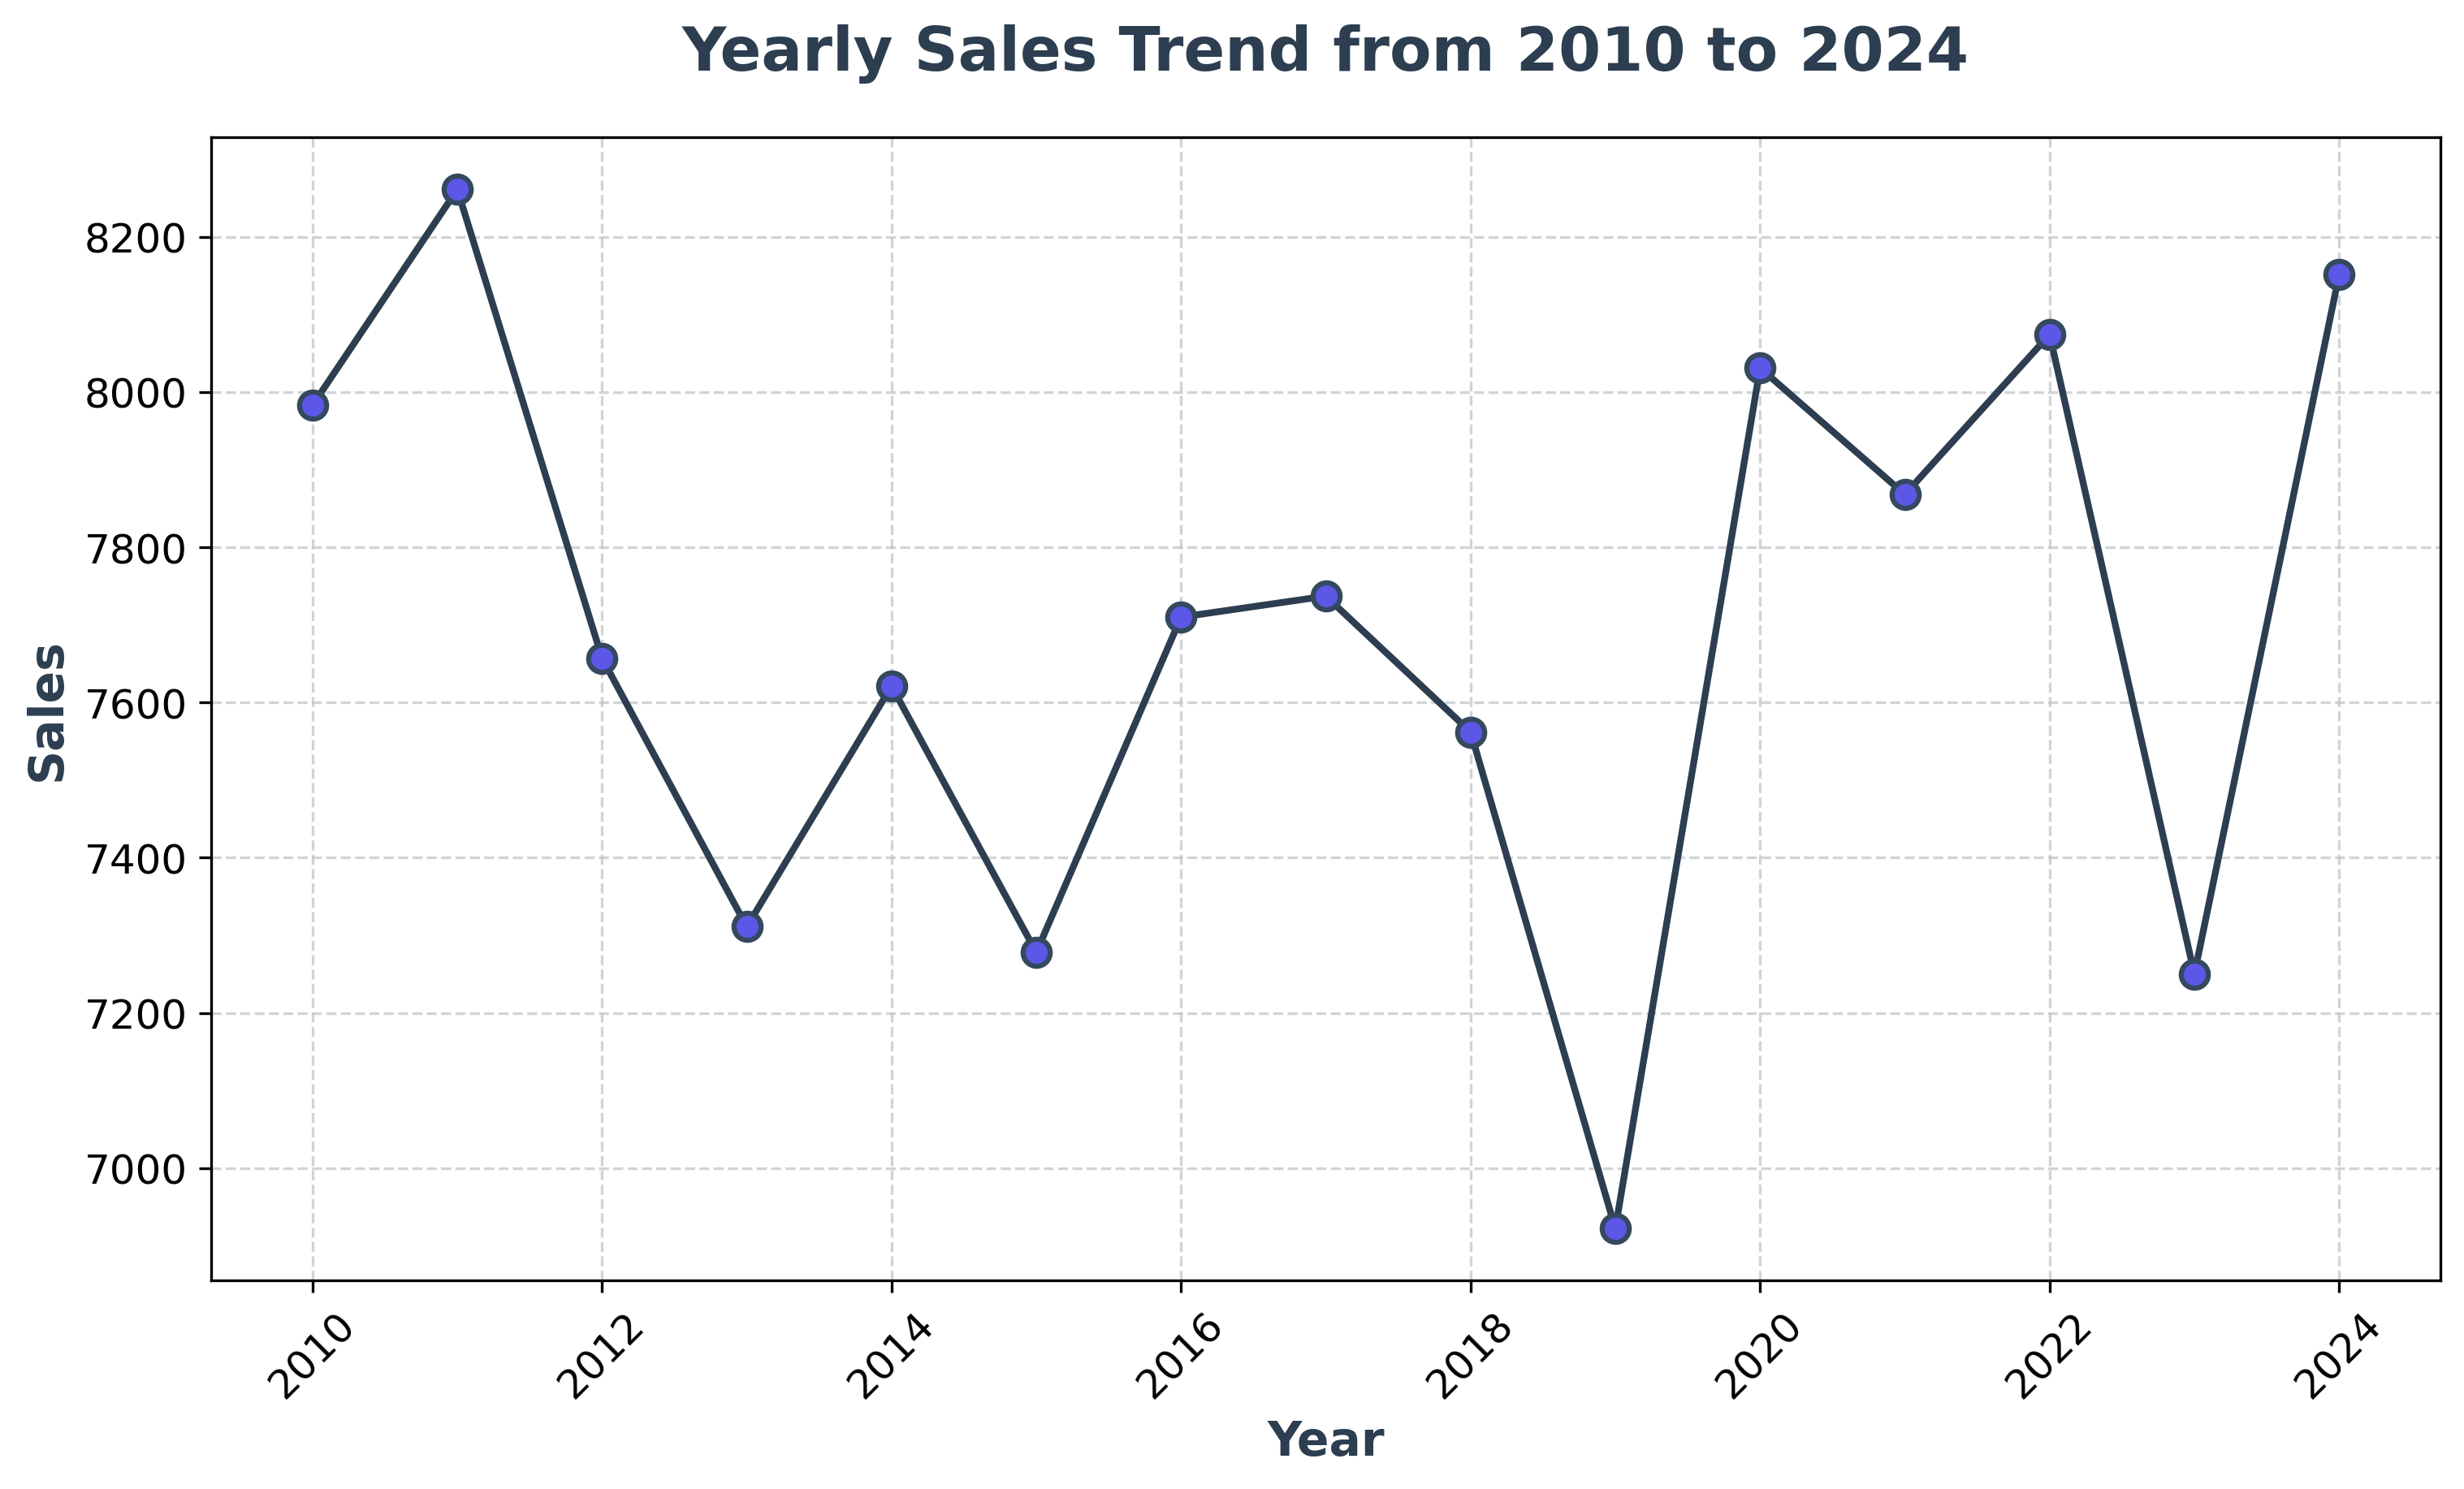

In [71]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(10, 6), dpi=300, constrained_layout=True
)

ax.plot(
    years,
    total_units_sold,
    color="#2c3e50",
    linestyle="-",
    linewidth=2,
    marker="o",
    markersize=8,
    markerfacecolor="#5c57e6",
    markeredgecolor="#34495e",
    markeredgewidth=1.5,
)

ax.grid(
    visible=True,
    which="major",
    axis="both",
    color="#bdc3c7",
    linestyle="--",
    linewidth=0.8,
    alpha=0.7,
)

ax.set_title(
    "Yearly Sales Trend from 2010 to 2024",
    fontsize=18,
    fontweight="bold",
    color="#2c3e50",
    pad=20,
)
ax.set_xlabel("Year", fontsize=14, fontweight="bold", color="#2c3e50")
ax.set_ylabel("Sales", fontsize=14, fontweight="bold", color="#2c3e50")

ax.tick_params(axis="x", rotation=45, labelsize=12)
ax.tick_params(axis="y", labelsize=12)

plt.savefig("images/yearly_sales_trend.png", dpi=1200, bbox_inches="tight")
plt.show()

### II. Regional Revenue Over Time

In [73]:
revenue_region_year = spark.sql(
    """
    select year, region, round(sum(revenue)) as total_revenue_per_region 
    from BMW
    group by year, region
    order by year
    """
)
revenue_region_year.show()

+----+-------------+------------------------+
|year|       region|total_revenue_per_region|
+----+-------------+------------------------+
|2010|       Europe|             9.2958486E7|
|2010|North America|             9.3113978E7|
|2010|       Africa|             9.9904804E7|
|2010|         Asia|             7.9502164E7|
|2010|South America|             8.1351226E7|
|2010|  Middle East|            1.01642761E8|
|2011|  Middle East|             8.6705063E7|
|2011|North America|             9.5960755E7|
|2011|       Africa|             8.4748241E7|
|2011|       Europe|            1.04979648E8|
|2011|South America|            1.12666376E8|
|2011|         Asia|             9.7598354E7|
|2012|South America|             9.4403674E7|
|2012|  Middle East|             8.1509936E7|
|2012|         Asia|             9.2250921E7|
|2012|       Africa|             9.6003338E7|
|2012|North America|            1.02305952E8|
|2012|       Europe|             8.3969034E7|
|2013|       Europe|             6

In [76]:
# Collect everything ONCE
rows = revenue_region_year.collect()

# region -> {year: revenue}
region_data = {}
for row in rows:
    region = row["region"]
    year = row["year"]
    revenue = row["total_revenue_per_region"]

    if region not in region_data:
        region_data[region] = {}
    region_data[region][year] = revenue

years = list(range(2010, 2025))

europe_values = [region_data.get("Europe", {}).get(y, 0) for y in years]
asia_values = [region_data.get("Asia", {}).get(y, 0) for y in years]
africa_values = [region_data.get("Africa", {}).get(y, 0) for y in years]
s_america_values = [region_data.get("South America", {}).get(y, 0) for y in years]
n_america_values = [region_data.get("North America", {}).get(y, 0) for y in years]

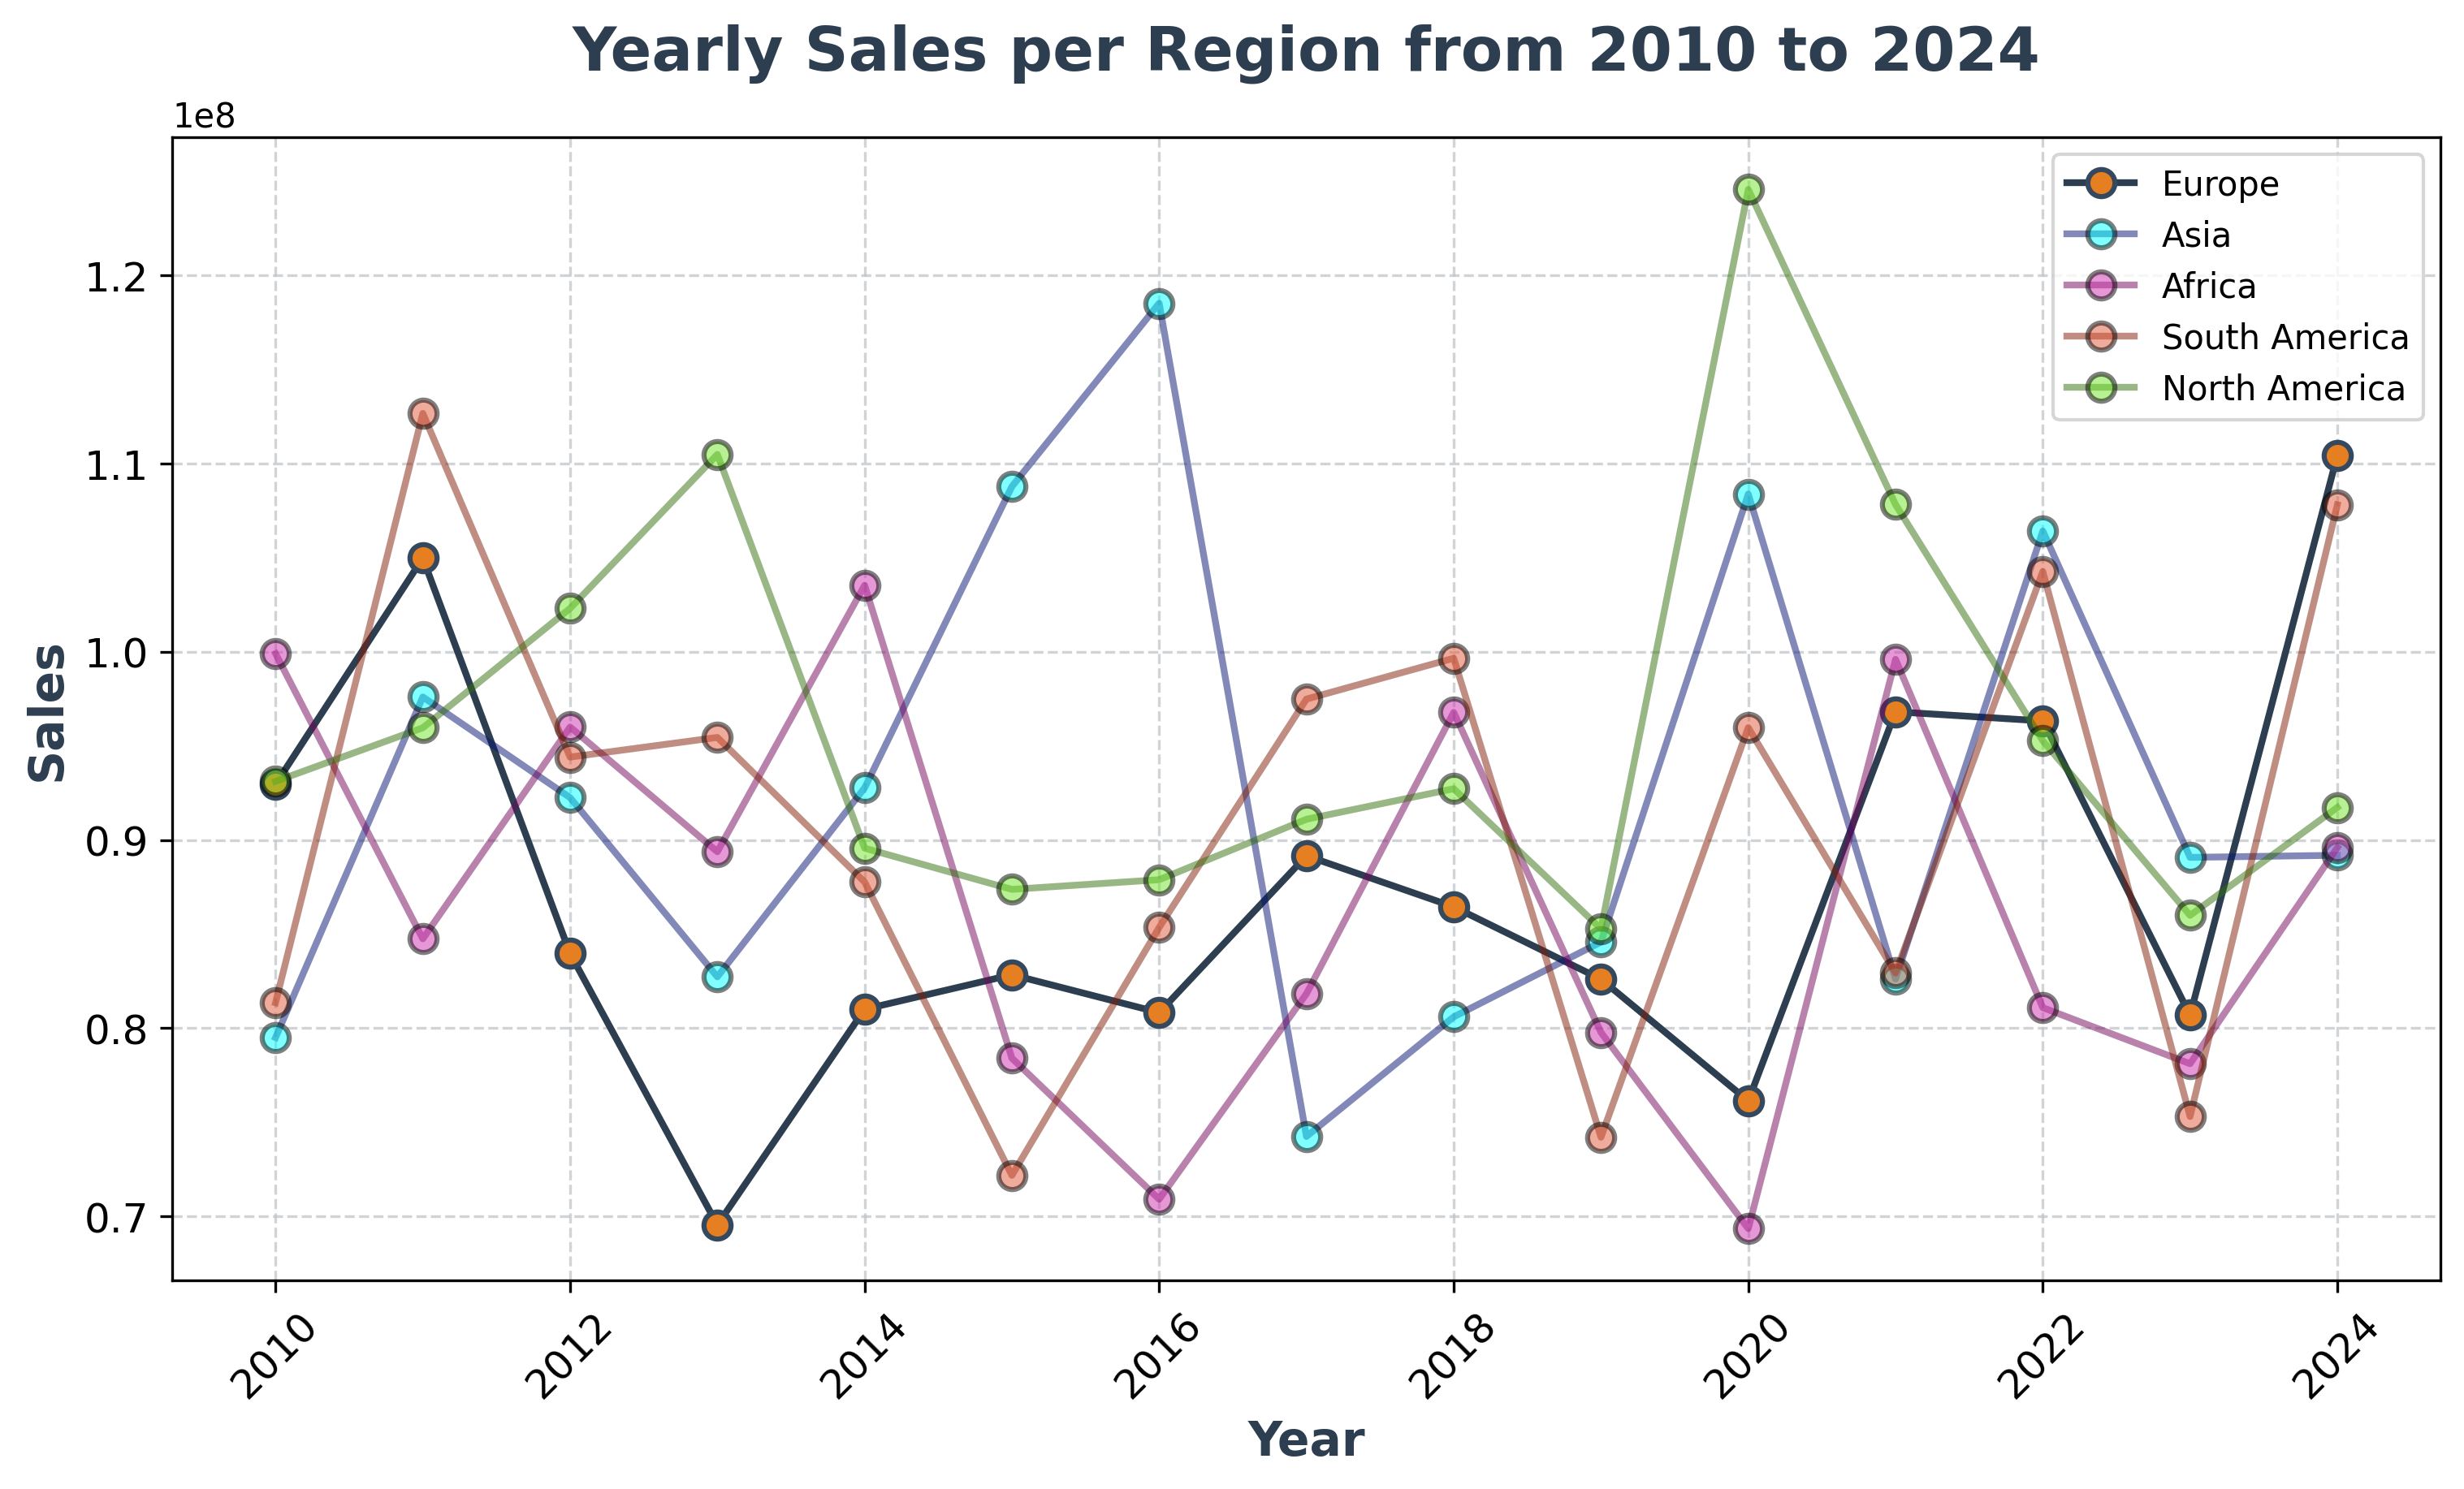

In [78]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(10, 6), dpi=300, constrained_layout=True
)

ax.plot(
    years,
    europe_values,
    color="#2c3e50",
    linestyle="-",
    linewidth=2,
    marker="o",
    markersize=8,
    markerfacecolor="#e67e22",
    markeredgecolor="#34495e",
    markeredgewidth=1.5,
    label="Europe",
)

ax.plot(
    years,
    asia_values,
    color="#071573",
    linestyle="-",
    linewidth=2,
    marker="o",
    markersize=8,
    markerfacecolor="cyan",
    markeredgecolor="black",
    markeredgewidth=1.5,
    label="Asia",
    alpha=0.5,
)

ax.plot(
    years,
    africa_values,
    color="#73075d",
    linestyle="-",
    linewidth=2,
    marker="o",
    markersize=8,
    markerfacecolor="#cc33ad",
    markeredgecolor="black",
    markeredgewidth=1.5,
    label="Africa",
    alpha=0.5,
)

ax.plot(
    years,
    s_america_values,
    color="#801d06",
    linestyle="-",
    linewidth=2,
    marker="o",
    markersize=8,
    markerfacecolor="#e0593a",
    markeredgecolor="black",
    markeredgewidth=1.5,
    label="South America",
    alpha=0.5,
)

ax.plot(
    years,
    n_america_values,
    color="#32700b",
    linestyle="-",
    linewidth=2,
    marker="o",
    markersize=8,
    markerfacecolor="#72e32b",
    markeredgecolor="black",
    markeredgewidth=1.5,
    label="North America",
    alpha=0.5,
)

ax.grid(
    visible=True,
    which="major",
    axis="both",
    color="#bdc3c7",
    linestyle="--",
    linewidth=0.8,
    alpha=0.7,
)

ax.set_title(
    "Yearly Sales per Region from 2010 to 2024",
    fontsize=18,
    fontweight="bold",
    color="#2c3e50",
    pad=20,
)
ax.set_xlabel("Year", fontsize=14, fontweight="bold", color="#2c3e50")
ax.set_ylabel("Sales", fontsize=14, fontweight="bold", color="#2c3e50")

ax.tick_params(axis="x", rotation=45, labelsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.legend()
plt.savefig("images/regional_revenue_over_time.png", dpi=1200, bbox_inches="tight")
plt.show()

### III. Top 5 Models Sold

In [79]:
models_units = spark.sql(
    """
    select model, sum(units_sold) as units_sold,
           rank() over (order by sum(units_sold) desc) as rank
    from bmw
    group by model
    order by units_sold desc
    """
)
models_units.show()

top5_performers = spark.sql(
    """
    select model, sum(units_sold) as units_sold 
    from bmw
    group by model
    order by units_sold desc
    limit 5
    """
)
top5_performers.show()

+--------+----------+----+
|   model|units_sold|rank|
+--------+----------+----+
|      M3|     10203|   1|
|      X6|      9933|   2|
|      X3|      9714|   3|
|      i8|      9713|   4|
|5 Series|      9662|   5|
|7 Series|      9654|   6|
|      X5|      9654|   6|
|      i3|      9569|   8|
|      Z4|      9559|   9|
|      M5|      9409|  10|
|3 Series|      9240|  11|
|      X1|      9106|  12|
+--------+----------+----+

+--------+----------+
|   model|units_sold|
+--------+----------+
|      M3|     10203|
|      X6|      9933|
|      X3|      9714|
|      i8|      9713|
|5 Series|      9662|
+--------+----------+



In [81]:
rows = top5_performers.collect()
models = [row["model"] for row in rows]
units_sold = [row["units_sold"] for row in rows]

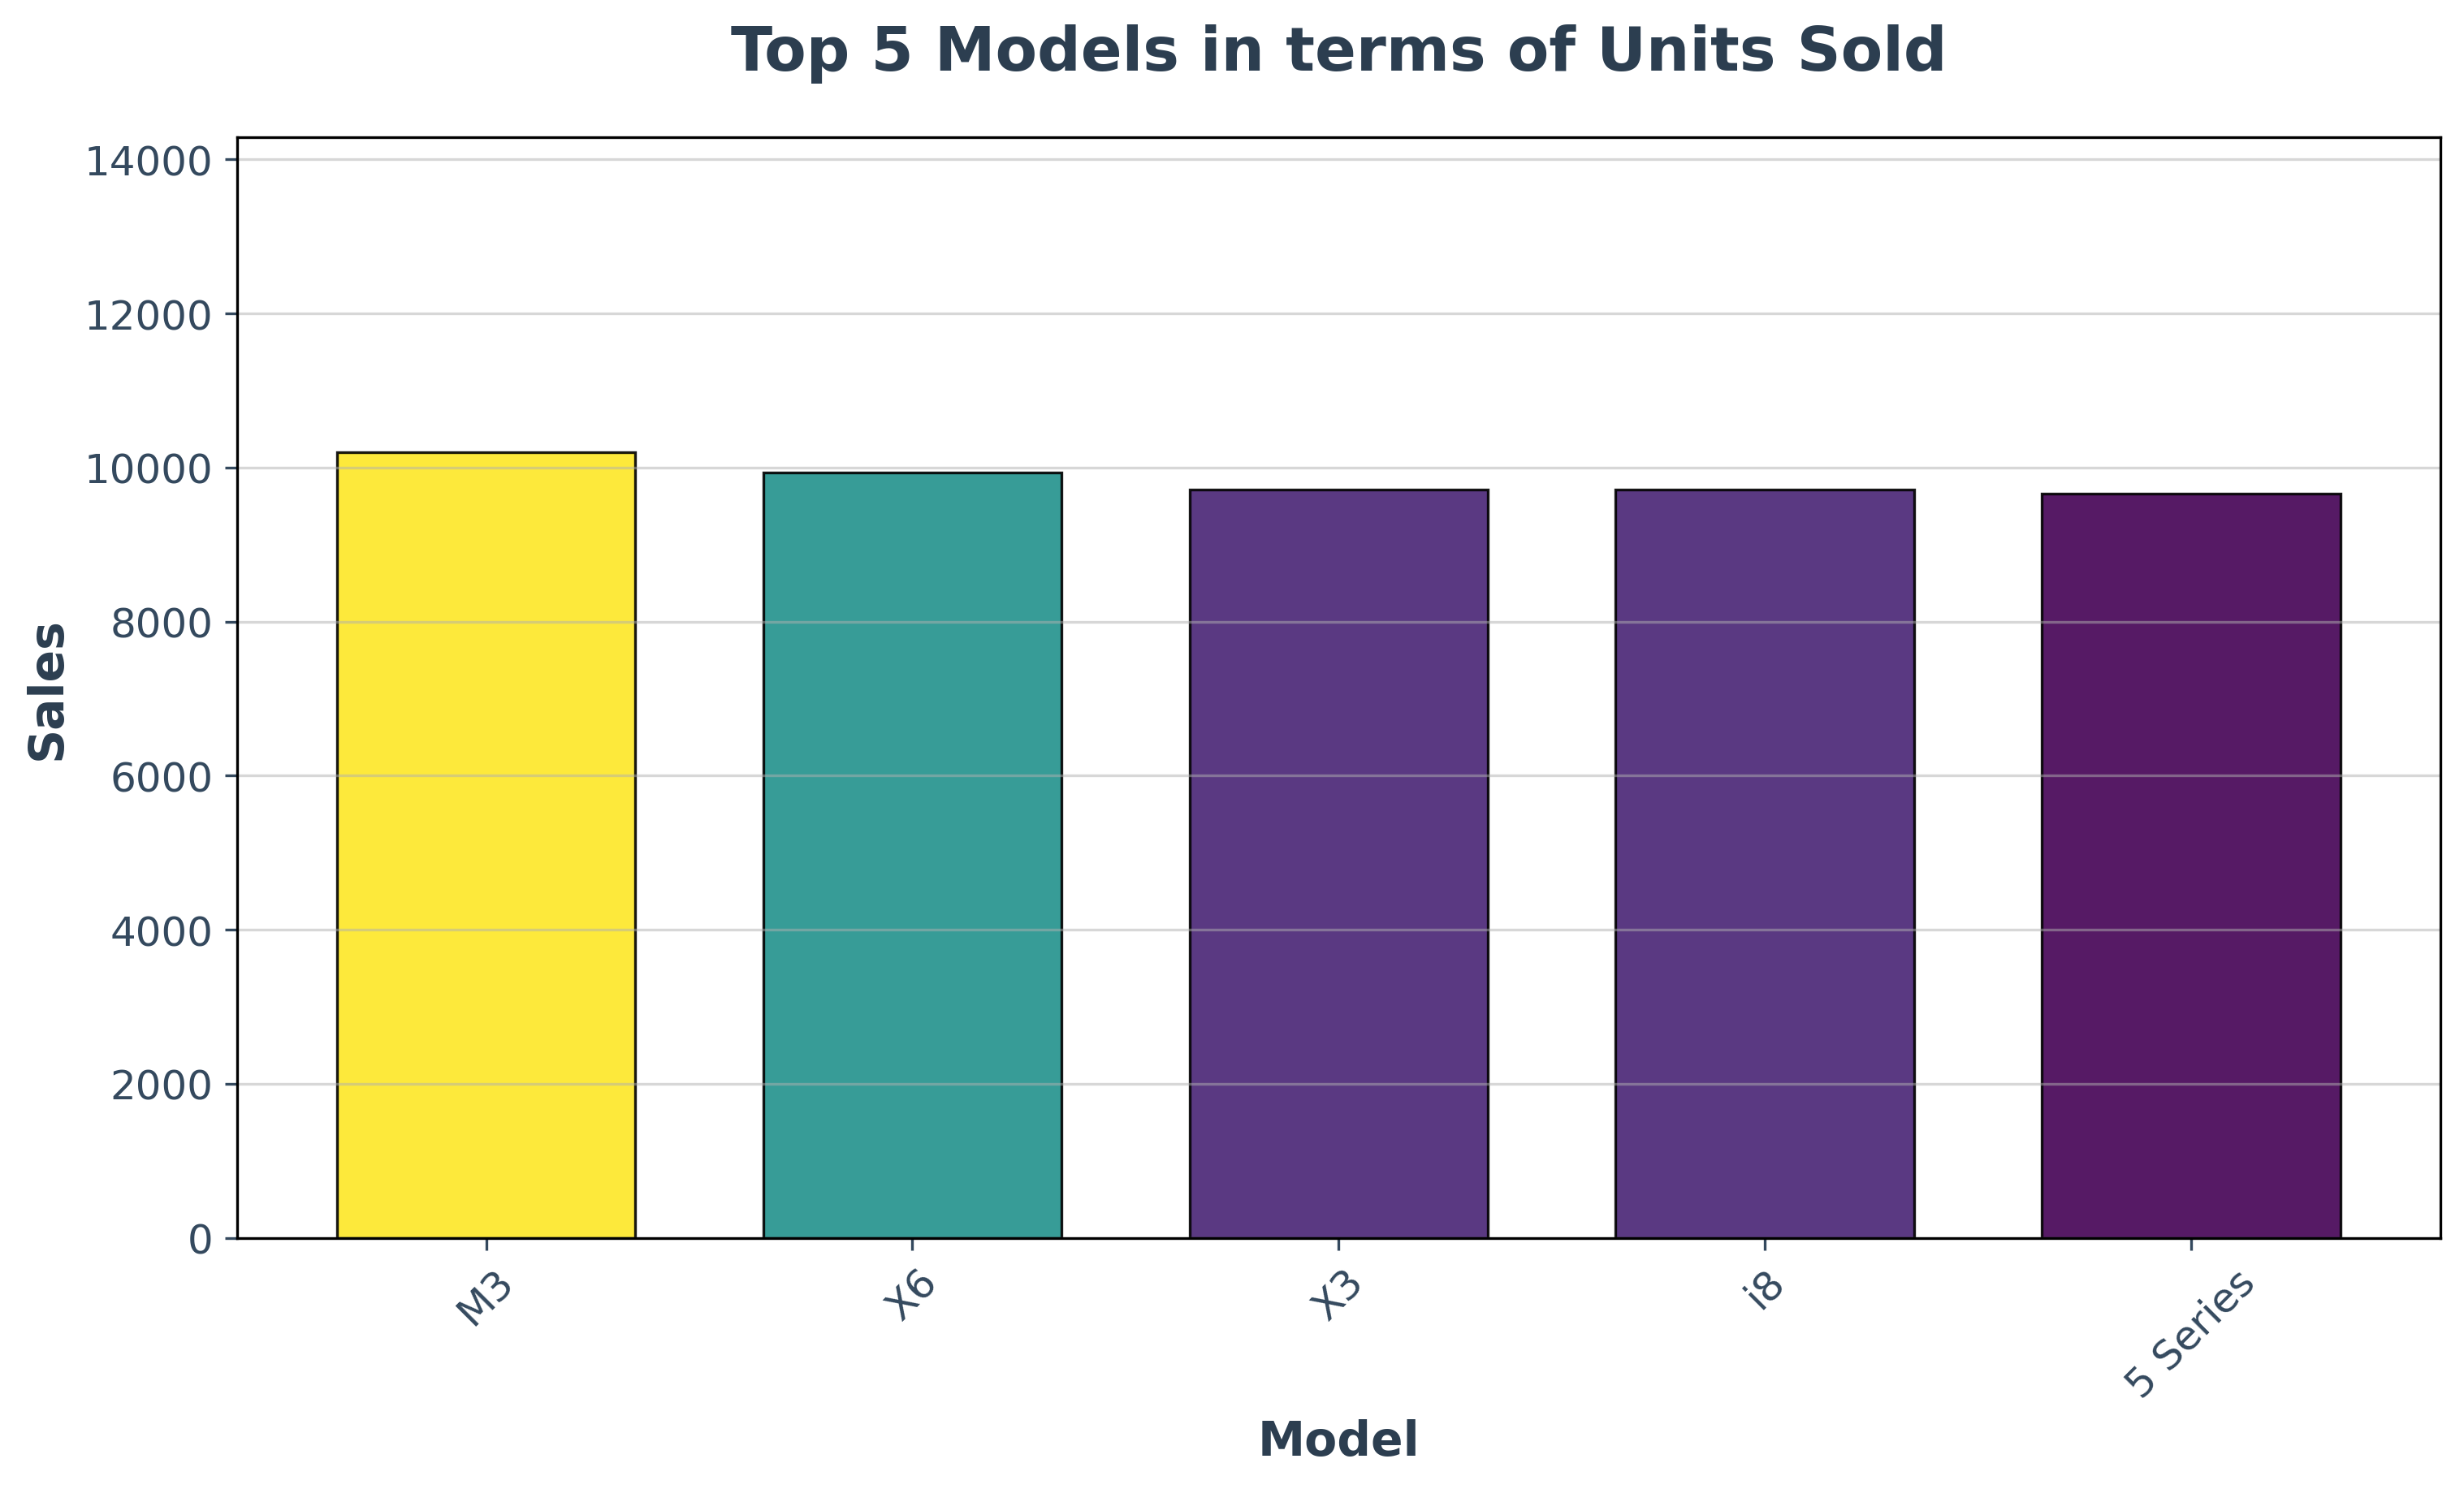

In [85]:
fig, ax = plt.subplots(
    figsize=(10, 6),
    dpi=300,
    constrained_layout=True,
)

# Kinda color map based on values
norm = plt.Normalize(min(units_sold), max(units_sold))
colors = cm.viridis(norm(units_sold))

bars = ax.bar(
    models,
    units_sold,
    width=0.7,
    edgecolor="black",
    linewidth=0.8,
    alpha=0.9,
    color=colors,
)

ax.set_title(
    "Top 5 Models in terms of Units Sold",
    fontsize=18,
    fontweight="bold",
    color="#2c3e50",
    pad=20,
)
ax.set_xlabel("Model", fontsize=14, fontweight="bold", color="#2c3e50")
ax.set_ylabel("Sales", fontsize=14, fontweight="bold", color="#2c3e50")

ax.tick_params(axis="x", rotation=45, labelsize=12, colors="#34495e")
ax.tick_params(axis="y", labelsize=12, colors="#34495e")

ax.grid(axis="y", linestyle="-", alpha=0.5)

ax.set_ylim(0, max(units_sold) * 1.4)
plt.savefig("images/top_5_models.png", dpi=1200, bbox_inches="tight")
plt.show()

### IV. Monthly Seasonality Heatmap

In [87]:
monthly_season_check = spark.sql(
    """
    select month, year, sum(units_sold) as units_sold
    from bmw
    group by month, year
    order by year, month desc
    """
)

hot_months = spark.sql(
    """
    select month, sum(units_sold) as units_sold, 
           dense_rank() over (order by sum(units_sold) desc) as rank
    from bmw
    group by month
    order by units_sold desc
"""
)

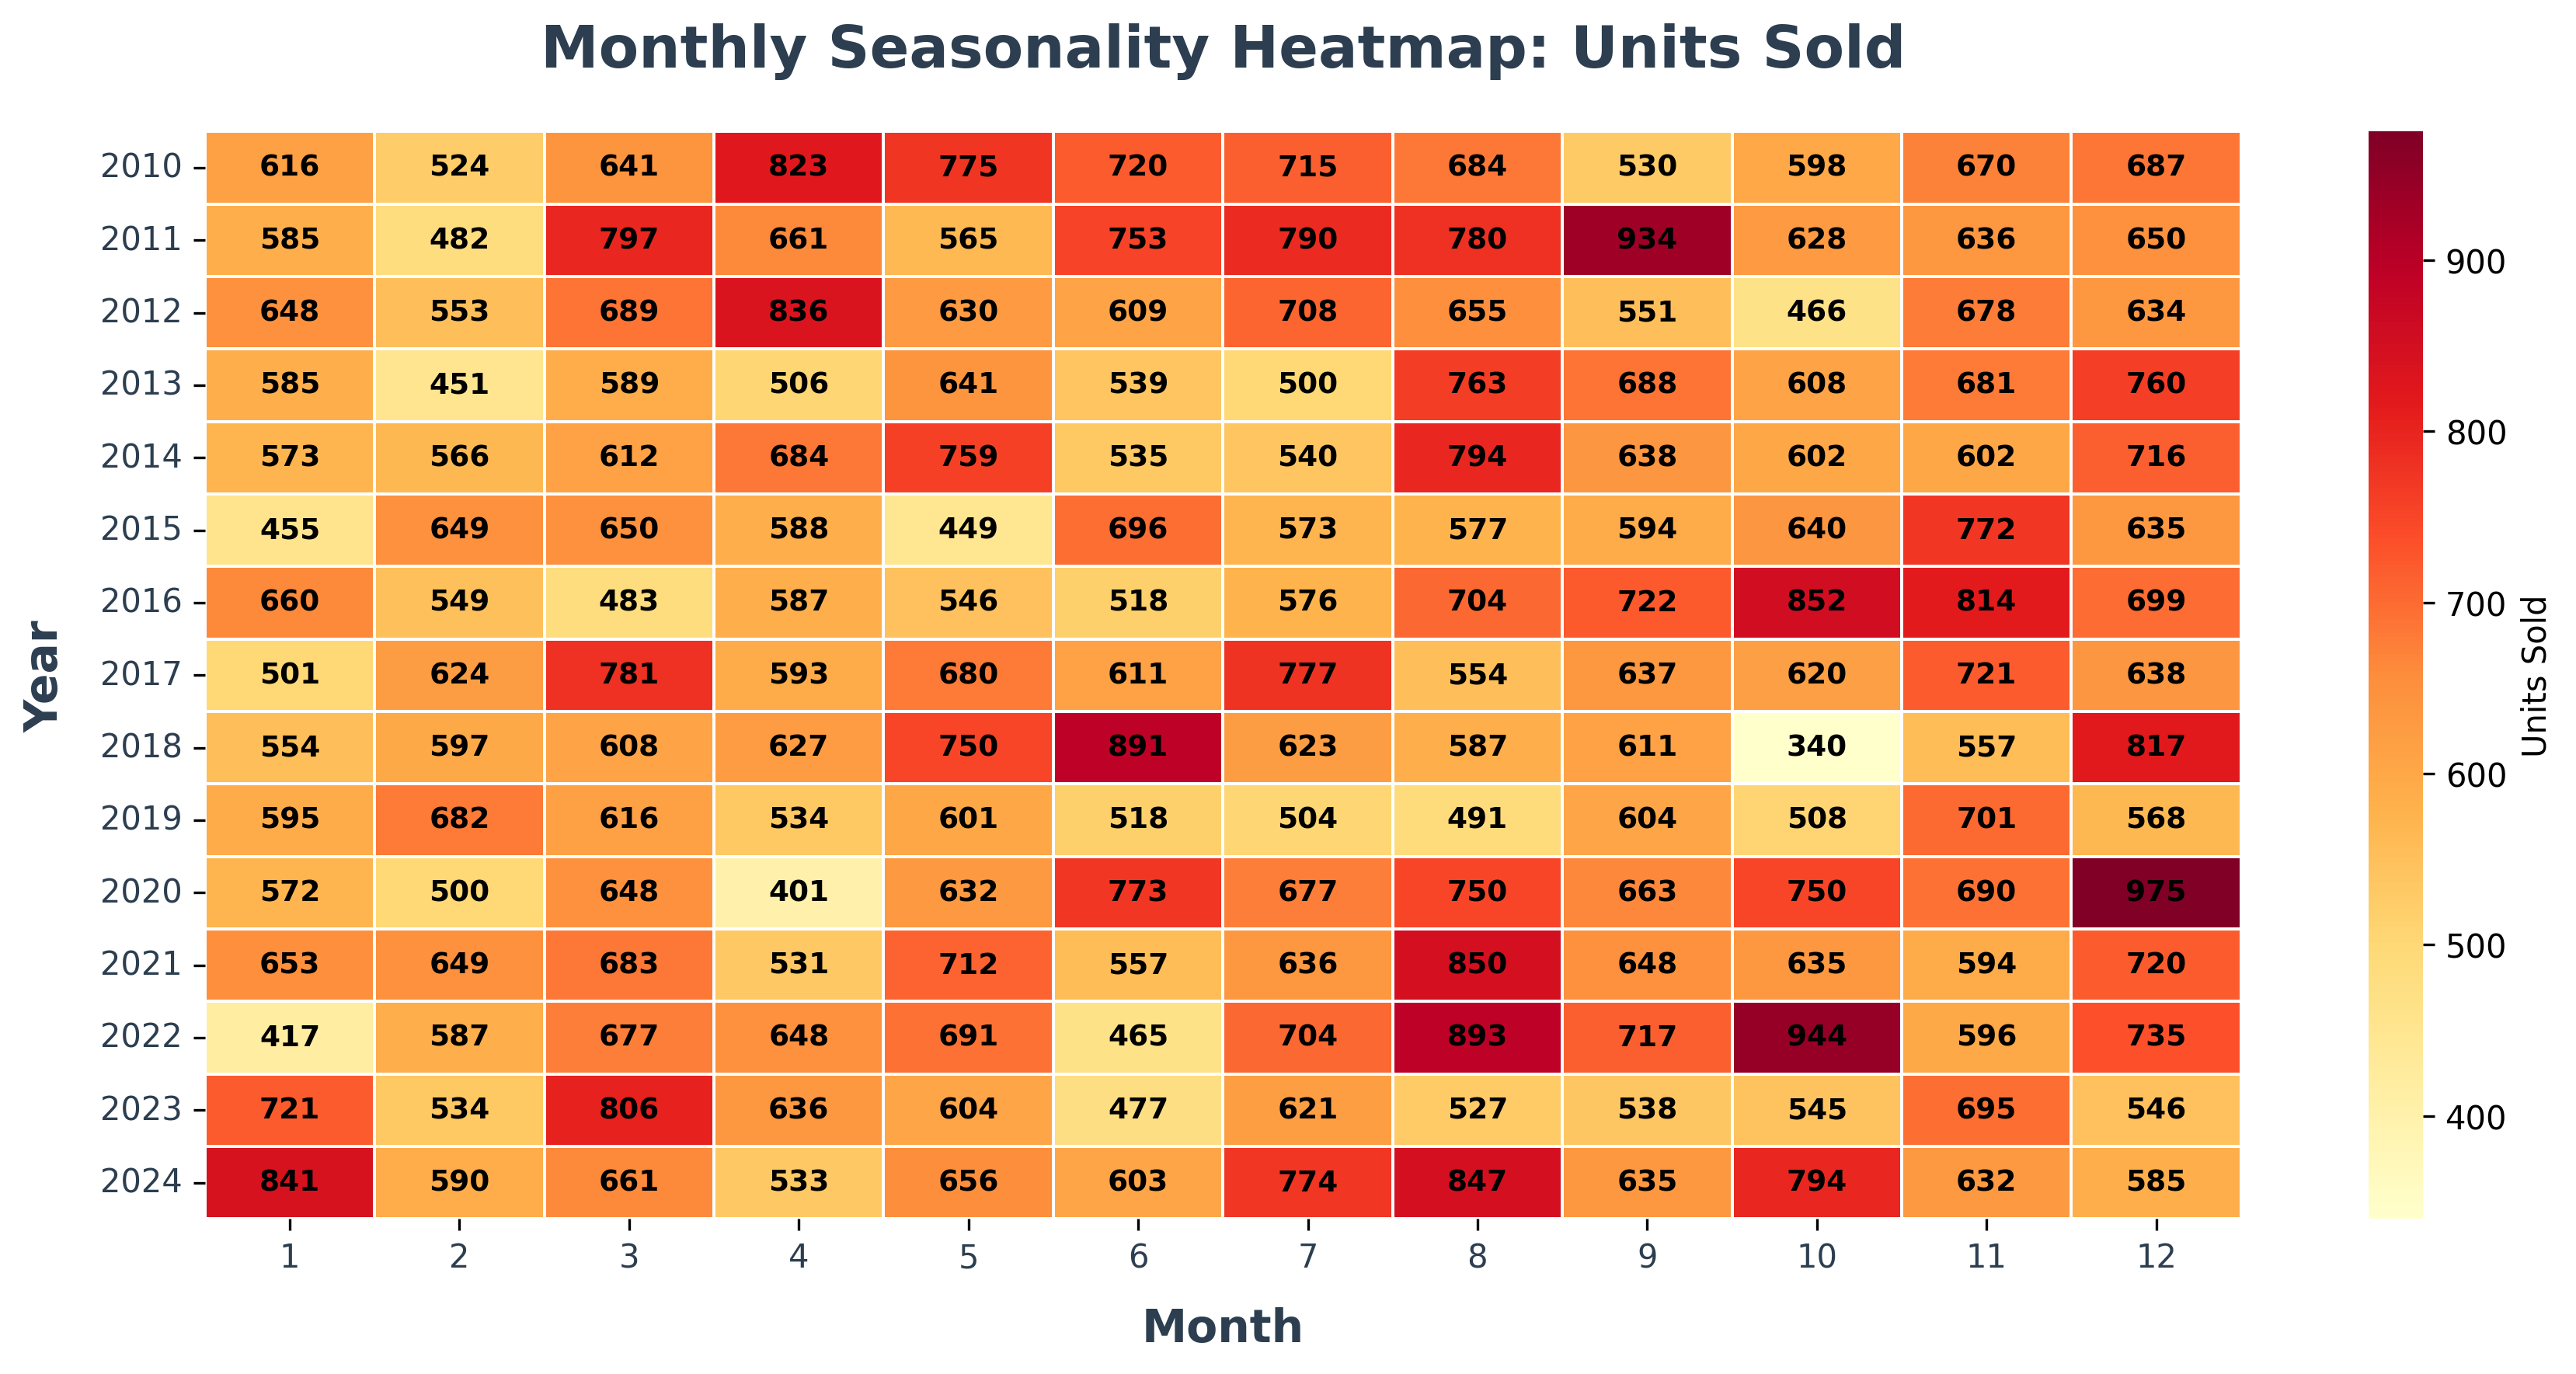

In [90]:
pdf = monthly_season_check.toPandas()
pdf = pdf.sort_values(["year", "month"])

heatmap_data = pdf.pivot(index="year", columns="month", values="units_sold")
plt.figure(figsize=(12, 6), dpi=300)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="YlOrRd",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Units Sold"},
    annot_kws={"size": 9, "weight": "bold", "color": "black"},
)

plt.title(
    "Monthly Seasonality Heatmap: Units Sold",
    fontsize=18,
    fontweight="bold",
    color="#2c3e50",
    pad=20,
)
plt.xlabel("Month", fontsize=14, fontweight="bold", color="#2c3e50", labelpad=10)
plt.ylabel("Year", fontsize=14, fontweight="bold", color="#2c3e50", labelpad=10)

plt.xticks(fontsize=10, color="#2c3e50")
plt.yticks(fontsize=10, color="#2c3e50")

plt.tight_layout()
plt.savefig("images/monthly_seasonality_heatmap.png", dpi=1200, bbox_inches="tight")
plt.show()

### Average Price Evolution

In [27]:
avg_price_per_year = spark.sql(
    """
    select year, round(avg(price)) as avg_price 
    from bmw
    group by year
    order by year
    """
)
avg_price_per_year.show()

weighted_avg_price_per_year = spark.sql(
    """
    select year, 
           round(sum(price * units_sold) / sum(units_sold), 2) as weighted_average
    from bmw
    group by year
    order by year asc                                                           
"""
)
weighted_avg_price_per_year.show()

+----+---------+
|year|avg_price|
+----+---------+
|2010|  69186.0|
|2011|  70760.0|
|2012|  71607.0|
|2013|  73974.0|
|2014|  71214.0|
|2015|  69887.0|
|2016|  69444.0|
|2017|  70845.0|
|2018|  70872.0|
|2019|  72052.0|
|2020|  71094.0|
|2021|  72136.0|
|2022|  72139.0|
|2023|  69374.0|
|2024|  72584.0|
+----+---------+

+----+----------------+
|year|weighted_average|
+----+----------------+
|2010|        68705.18|
|2011|        70531.22|
|2012|        71887.54|
|2013|        73463.76|
|2014|        71907.35|
|2015|        69936.18|
|2016|         69792.5|
|2017|        70607.24|
|2018|        71610.08|
|2019|        72716.19|
|2020|        71324.32|
|2021|        72844.99|
|2022|        72027.41|
|2023|        68944.49|
|2024|        72918.11|
+----+----------------+



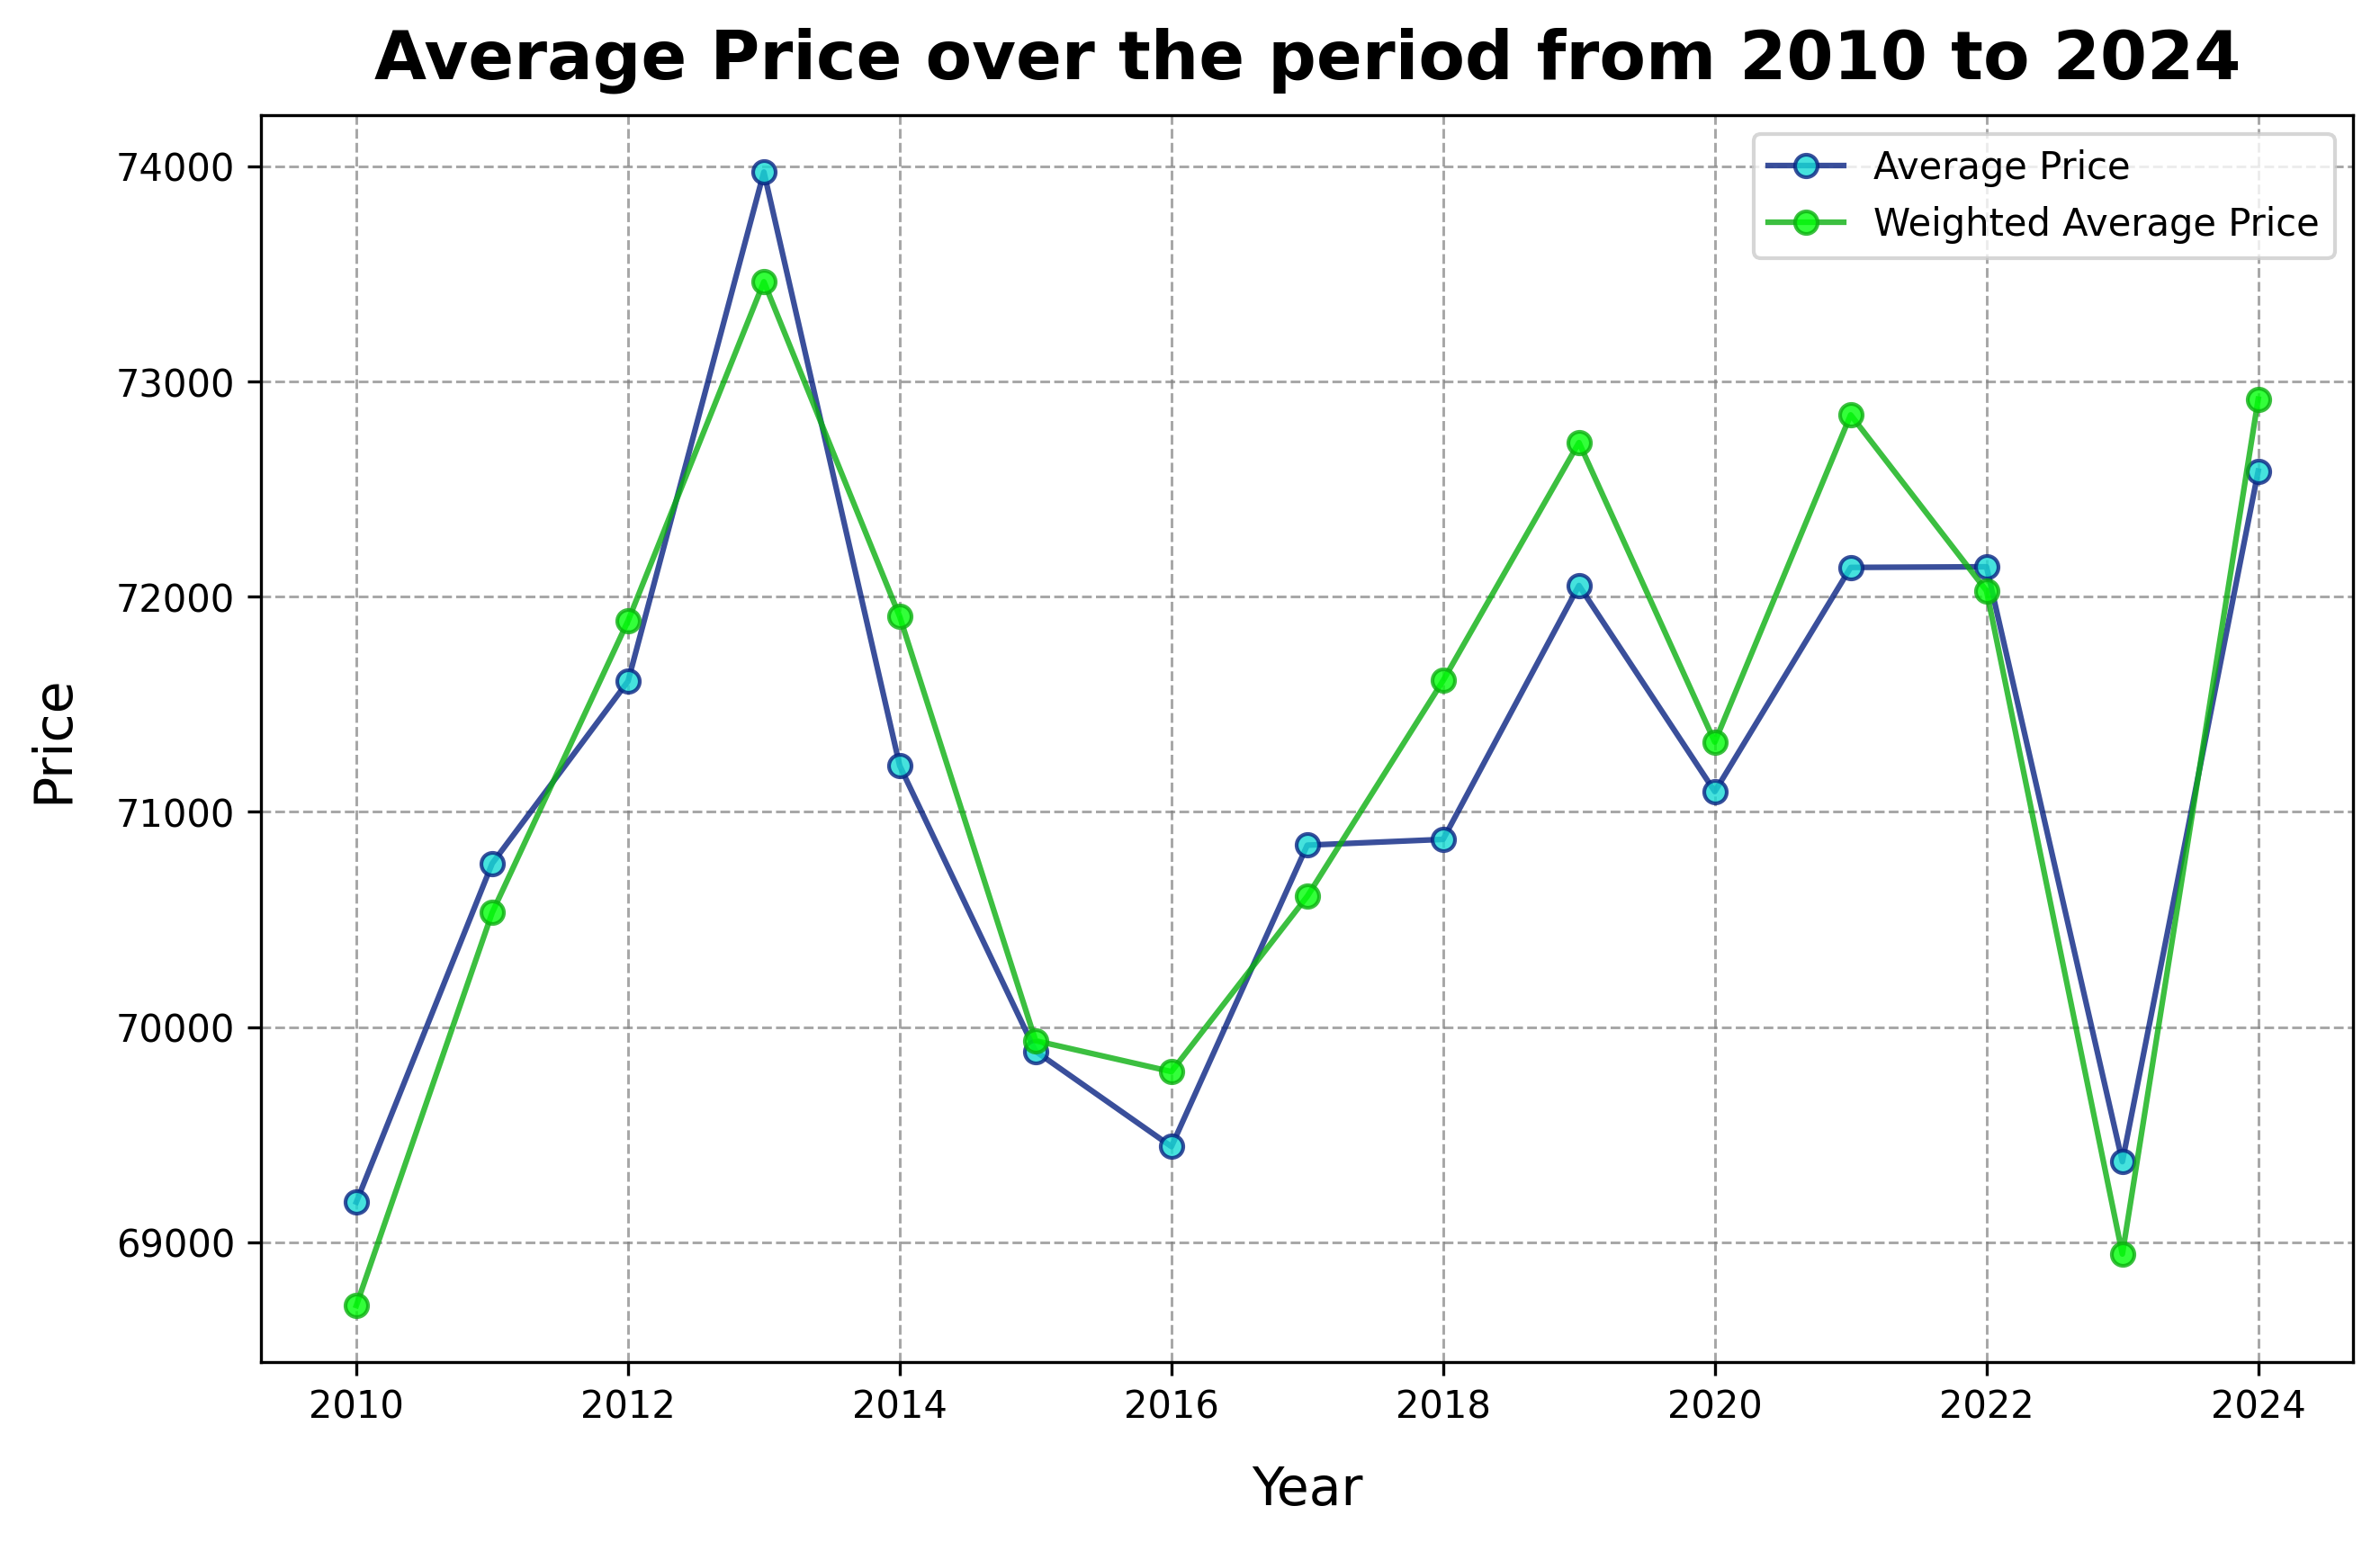

In [122]:
years = [year for year in range(2010, 2025)]
average_price = [row["avg_price"] for row in avg_price_per_year.collect()]
average_price_weighted = [
    row["weighted_average"] for row in weighted_avg_price_per_year.collect()
]

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax.plot(
    years,
    average_price,
    color="#092382",
    marker="o",
    markerfacecolor="#16dbd5",
    markeredgecolor="#092382",
    alpha=0.8,
    label="Average Price",
)
ax.plot(
    years,
    average_price_weighted,
    color="#0bb010",
    marker="o",
    markerfacecolor="#00ff08",
    markeredgecolor="#0bb010",
    alpha=0.8,
    label="Weighted Average Price",
)


ax.grid(
    visible=True,
    which="major",
    axis="both",
    color="gray",
    linestyle="--",
    linewidth=0.7,
    alpha=0.7,
)

ax.set_title(
    "Average Price over the period from 2010 to 2024",
    fontsize=18,
    fontweight="bold",
    color="black",
    loc="center",
    pad=10,
)
ax.set_xlabel(
    xlabel="Year",
    fontsize=14,
    color="black",
    labelpad=10,
    loc="center",
)
ax.set_ylabel(ylabel="Price", fontsize=14, color="black", labelpad=10, loc="center")

ax.legend()
plt.show()

### Fuel Type Share

In [55]:
fuel_type_breakdown = spark.sql(
    """
    select fuel_type, 
           sum(units_sold) as total_units_sold,
           sum(revenue) as total_revenue 
    from BMW
    group by fuel_type
    order by total_units_sold desc
    """
)
fuel_type_breakdown.show()

+---------+----------------+--------------------+
|fuel_type|total_units_sold|       total_revenue|
+---------+----------------+--------------------+
|   Diesel|           29133| 2.052416262180004E9|
|   Hybrid|           28855| 2.048510684599996E9|
| Electric|           28824|2.0809308148499987E9|
|   Petrol|           28604| 2.044759683809999E9|
+---------+----------------+--------------------+



In [57]:
rows = fuel_type_breakdown.collect()
total_units_sold = [row["total_units_sold"] for row in rows]
fuel_type = [row["fuel_type"] for row in rows]

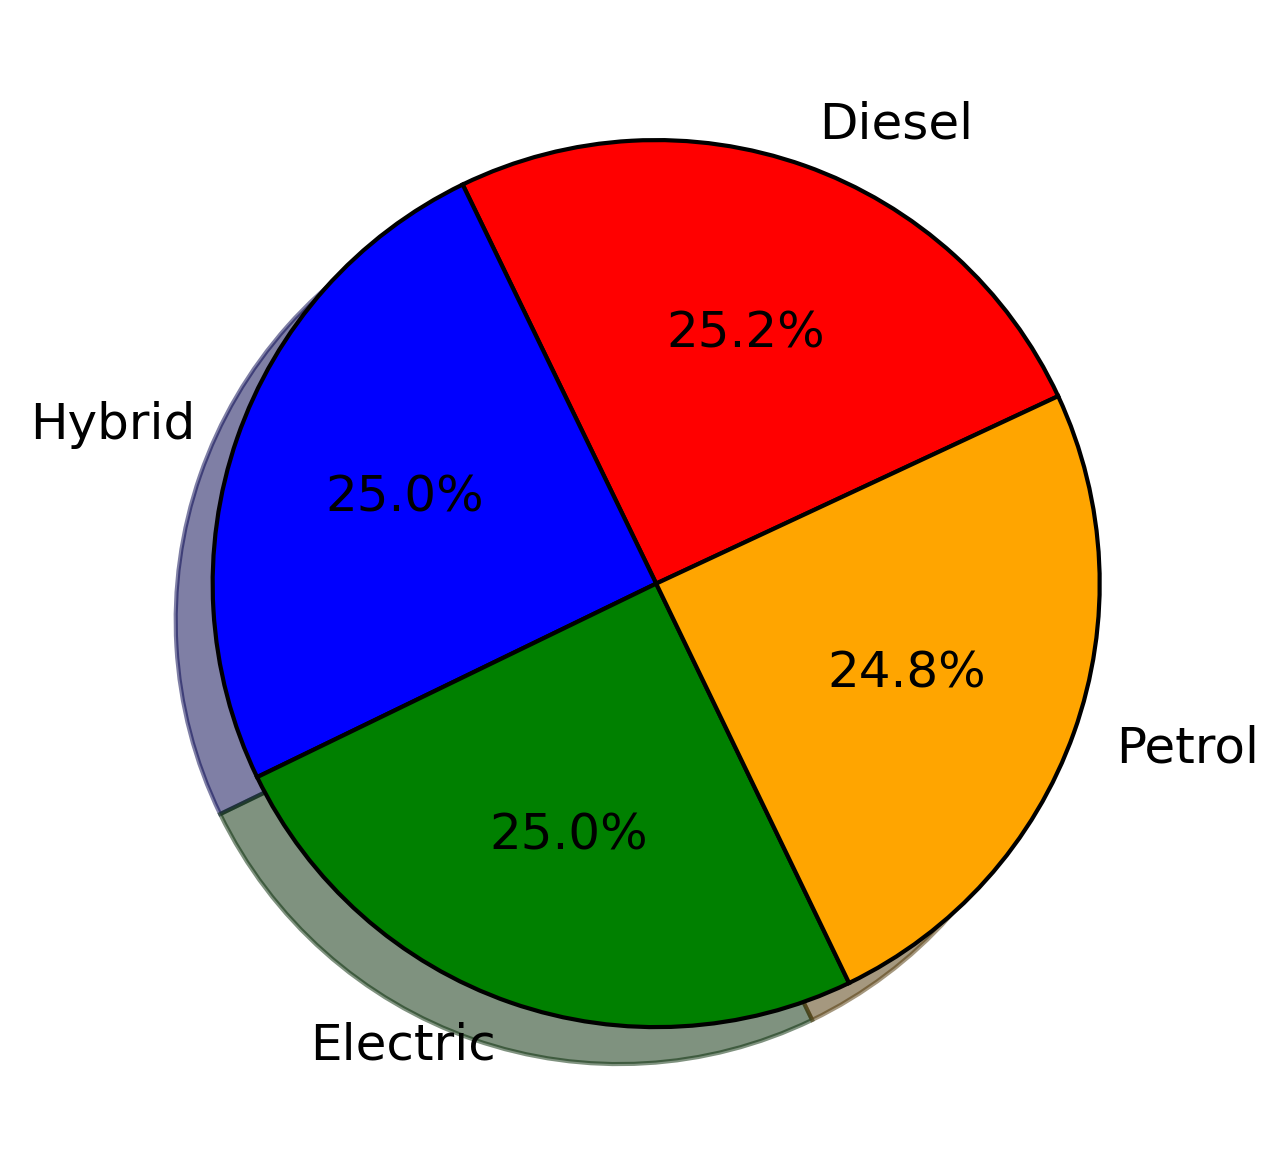

In [63]:
fig, ax = plt.subplots(dpi=300)
ax.pie(
    total_units_sold,
    labels=fuel_type,
    autopct="%1.1f%%",
    startangle=25,
    colors=["red", "blue", "green", "orange"],
    shadow=True,
    radius=1.0,
    counterclock=True,
    wedgeprops={"linewidth": 1, "edgecolor": "black"},
    textprops={"fontsize": 12, "color": "black"},
)
plt.show()

### Transmission Preference by Region

In [31]:
transmission_preference = spark.sql(
    """
    select region, transmission, count(transmission) as total_number 
    from bmw
    group by region, transmission
    order by region, transmission
    """
)
transmission_preference.show()

regions_manuals = spark.sql(
    """
    select region, count(*) as manual_cars_sold
    from bmw
    where transmission = 'Manual'
    group by region
    order by manual_cars_sold desc
    """
)
regions_manuals.show()

+-------------+------------+------------+
|       region|transmission|total_number|
+-------------+------------+------------+
|       Africa|   Automatic|         436|
|       Africa|      Manual|         429|
|         Asia|   Automatic|         462|
|         Asia|      Manual|         470|
|       Europe|   Automatic|         441|
|       Europe|      Manual|         465|
|  Middle East|   Automatic|         441|
|  Middle East|      Manual|         484|
|North America|   Automatic|         493|
|North America|      Manual|         472|
|South America|   Automatic|         453|
|South America|      Manual|         454|
+-------------+------------+------------+

+-------------+----------------+
|       region|manual_cars_sold|
+-------------+----------------+
|  Middle East|             484|
|North America|             472|
|         Asia|             470|
|       Europe|             465|
|South America|             454|
|       Africa|             429|
+-------------+---------------

In [37]:
rows = transmission_preference.collect()
regions = ["Africa", "Asia", "Europe", "Middle East", "North America", "South America"]
manuals_values = [
    row["total_number"]
    for row in transmission_preference.filter(col("transmission") == "Manual").collect()
]
automatic_values = [
    row["total_number"]
    for row in transmission_preference.filter(
        col("transmission") == "Automatic"
    ).collect()
]

In [40]:
region_values = {}


def function(region, manual, automatic):
    region_values[region] = [manual, automatic]
    return region, [manual, automatic]


res = list(map(function, regions, manuals_values, automatic_values))
print(region_values)

{'Africa': [429, 436], 'Asia': [470, 462], 'Europe': [465, 441], 'Middle East': [484, 441], 'North America': [472, 493], 'South America': [454, 453]}


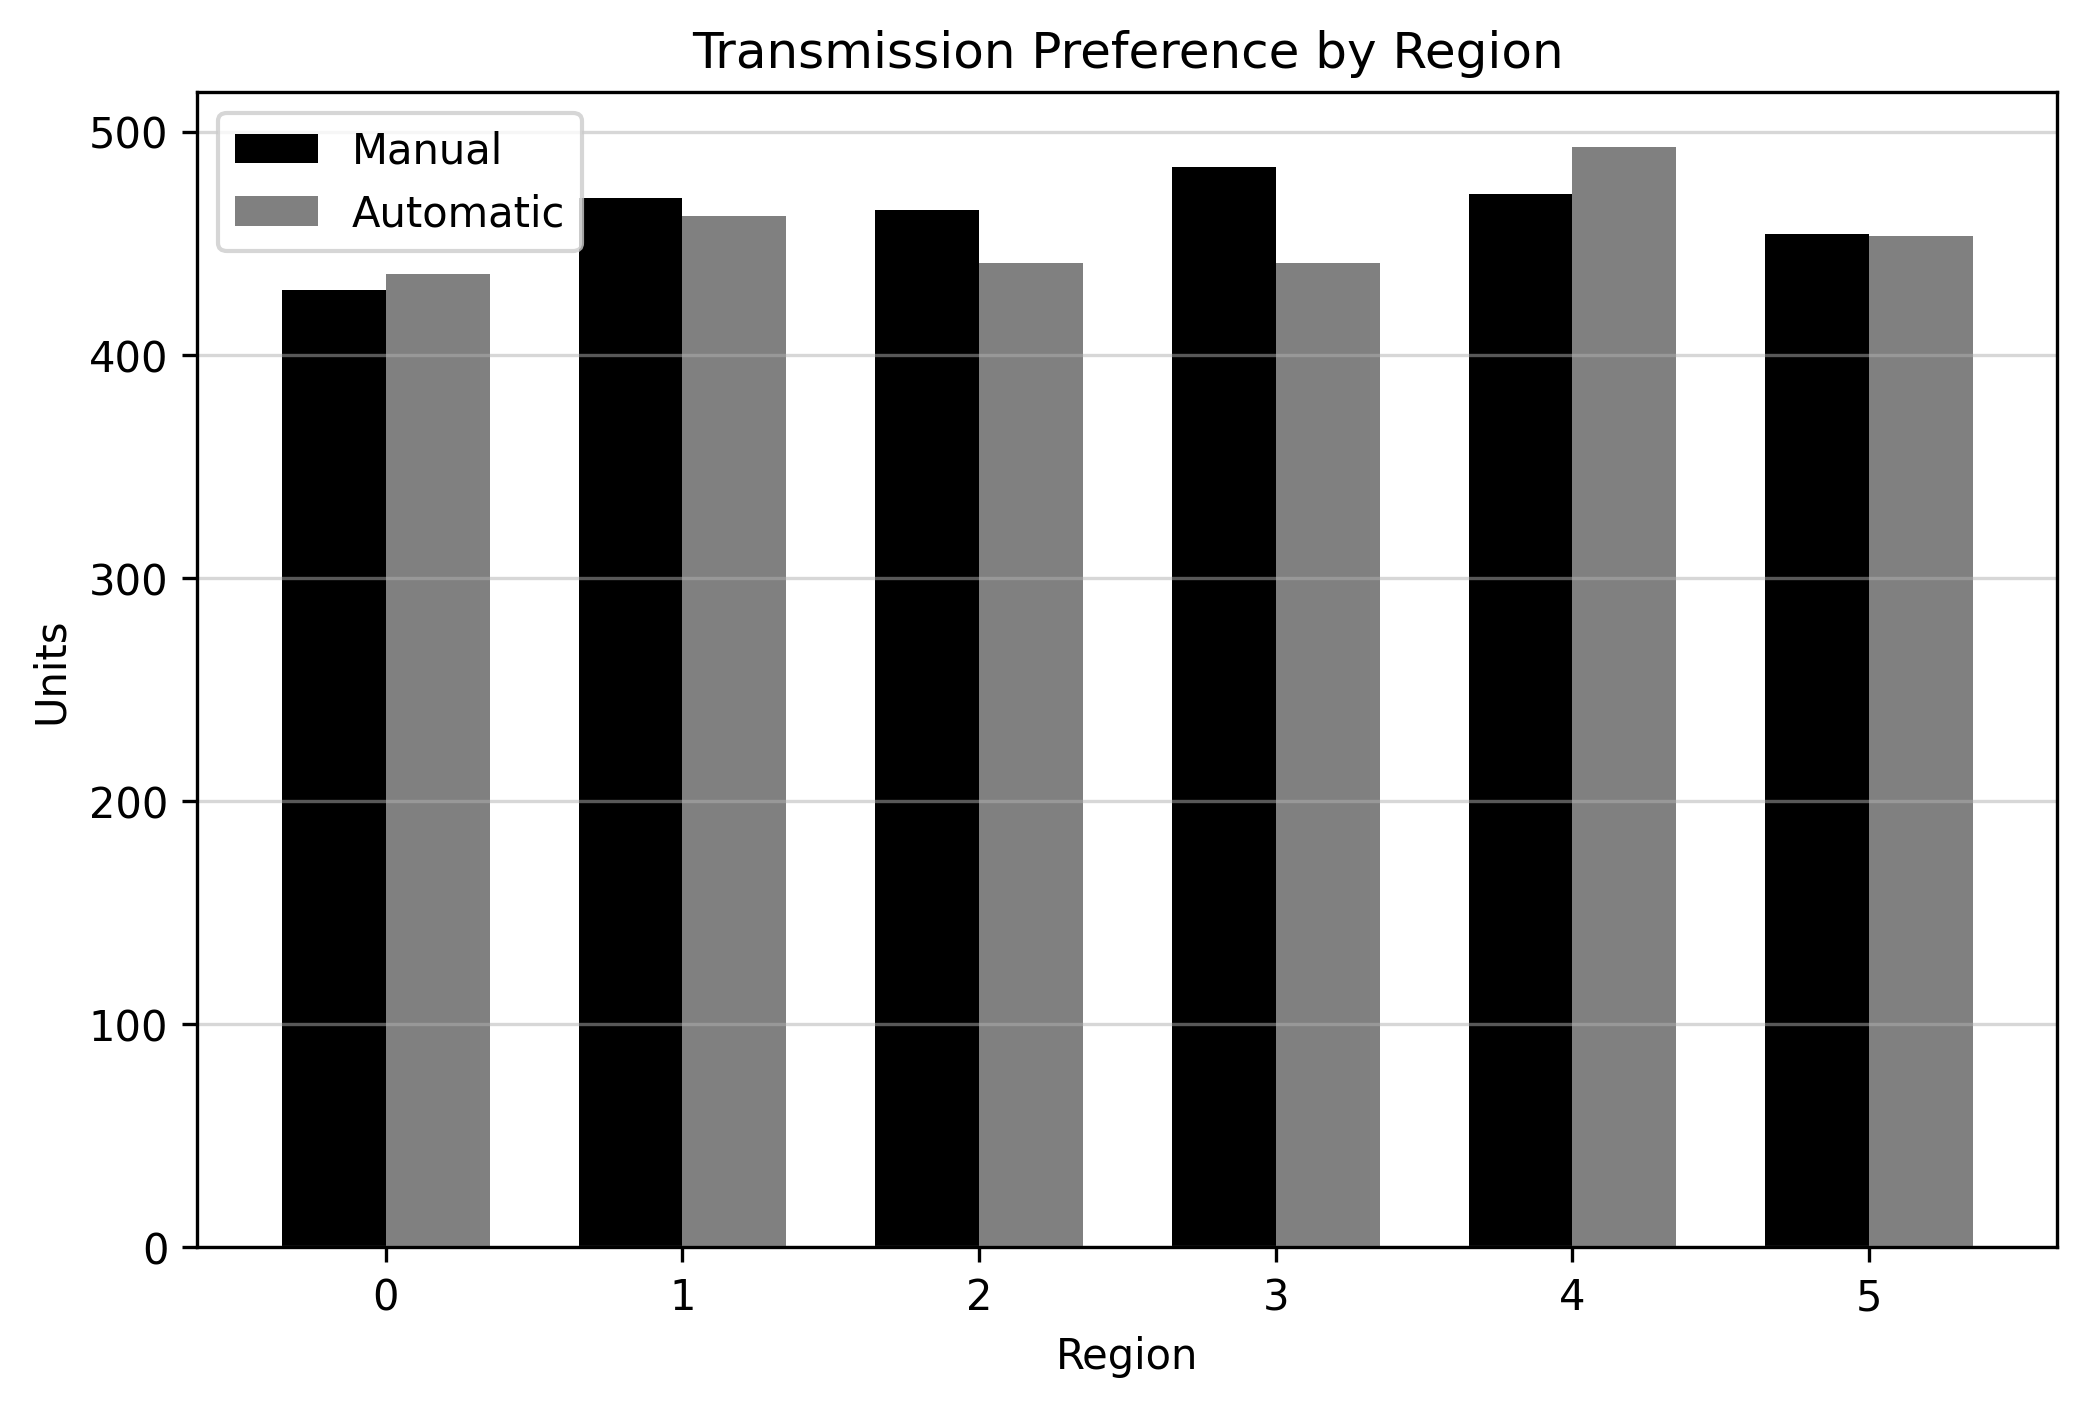

In [53]:
manuals = [vals[0] for vals in region_values.values()]
automatics = [vals[1] for vals in region_values.values()]

x = np.arange(len(regions))  # positions
width = 0.35  # bar width

fig, ax = plt.subplots(dpi=300, figsize=(8, 5))
ax.bar(x - width / 2, manuals, width, label="Manual", color="black")
ax.bar(x + width / 2, automatics, width, label="Automatic", color="gray")

ax.set_xlabel("Region")
ax.set_ylabel("Units")
ax.set_title("Transmission Preference by Region")
ax.set_xticks(x)
ax.legend()

ax.grid(axis="y", linestyle="-", alpha=0.5)
plt.show()

### VIII. Dealer Performance Leaderboard

In [109]:
dealers = spark.sql(
    """
    select 
          dealer, 
          region, 
          sum(revenue) as total_revenue
    from bmw
    group by dealer, region
    order by total_revenue desc
    """
)

top_dealers = spark.sql(
    """
    select 
          dealer, 
          region, 
          sum(revenue) as total_revenue
    from bmw
    group by dealer, region
    order by total_revenue desc
    limit 10
    """
)

In [110]:
top10_dealers = spark.sql(
    """
    select dealer, sum(revenue) as total_revenue
    from bmw
    group by dealer
    order by total_revenue desc
    limit 10                                                    
    """
)

top10_dealers.show()

+---------+--------------------+
|   dealer|       total_revenue|
+---------+--------------------+
|Dealer_48|2.0340747501000005E8|
|Dealer_11|1.9592311735000008E8|
|Dealer_10|1.9181910854999995E8|
|Dealer_44|1.9087026315999997E8|
|Dealer_14|1.9081135998999995E8|
| Dealer_8|1.8966092990999997E8|
|Dealer_49| 1.814467639399999E8|
|Dealer_35|      1.8090814836E8|
|Dealer_37|1.8056607623000002E8|
| Dealer_4|      1.7867144119E8|
+---------+--------------------+



In [113]:
rows = top10_dealers.collect()
dealers = [row["dealer"] for row in rows]
total_revenue = [row["total_revenue"] for row in rows]

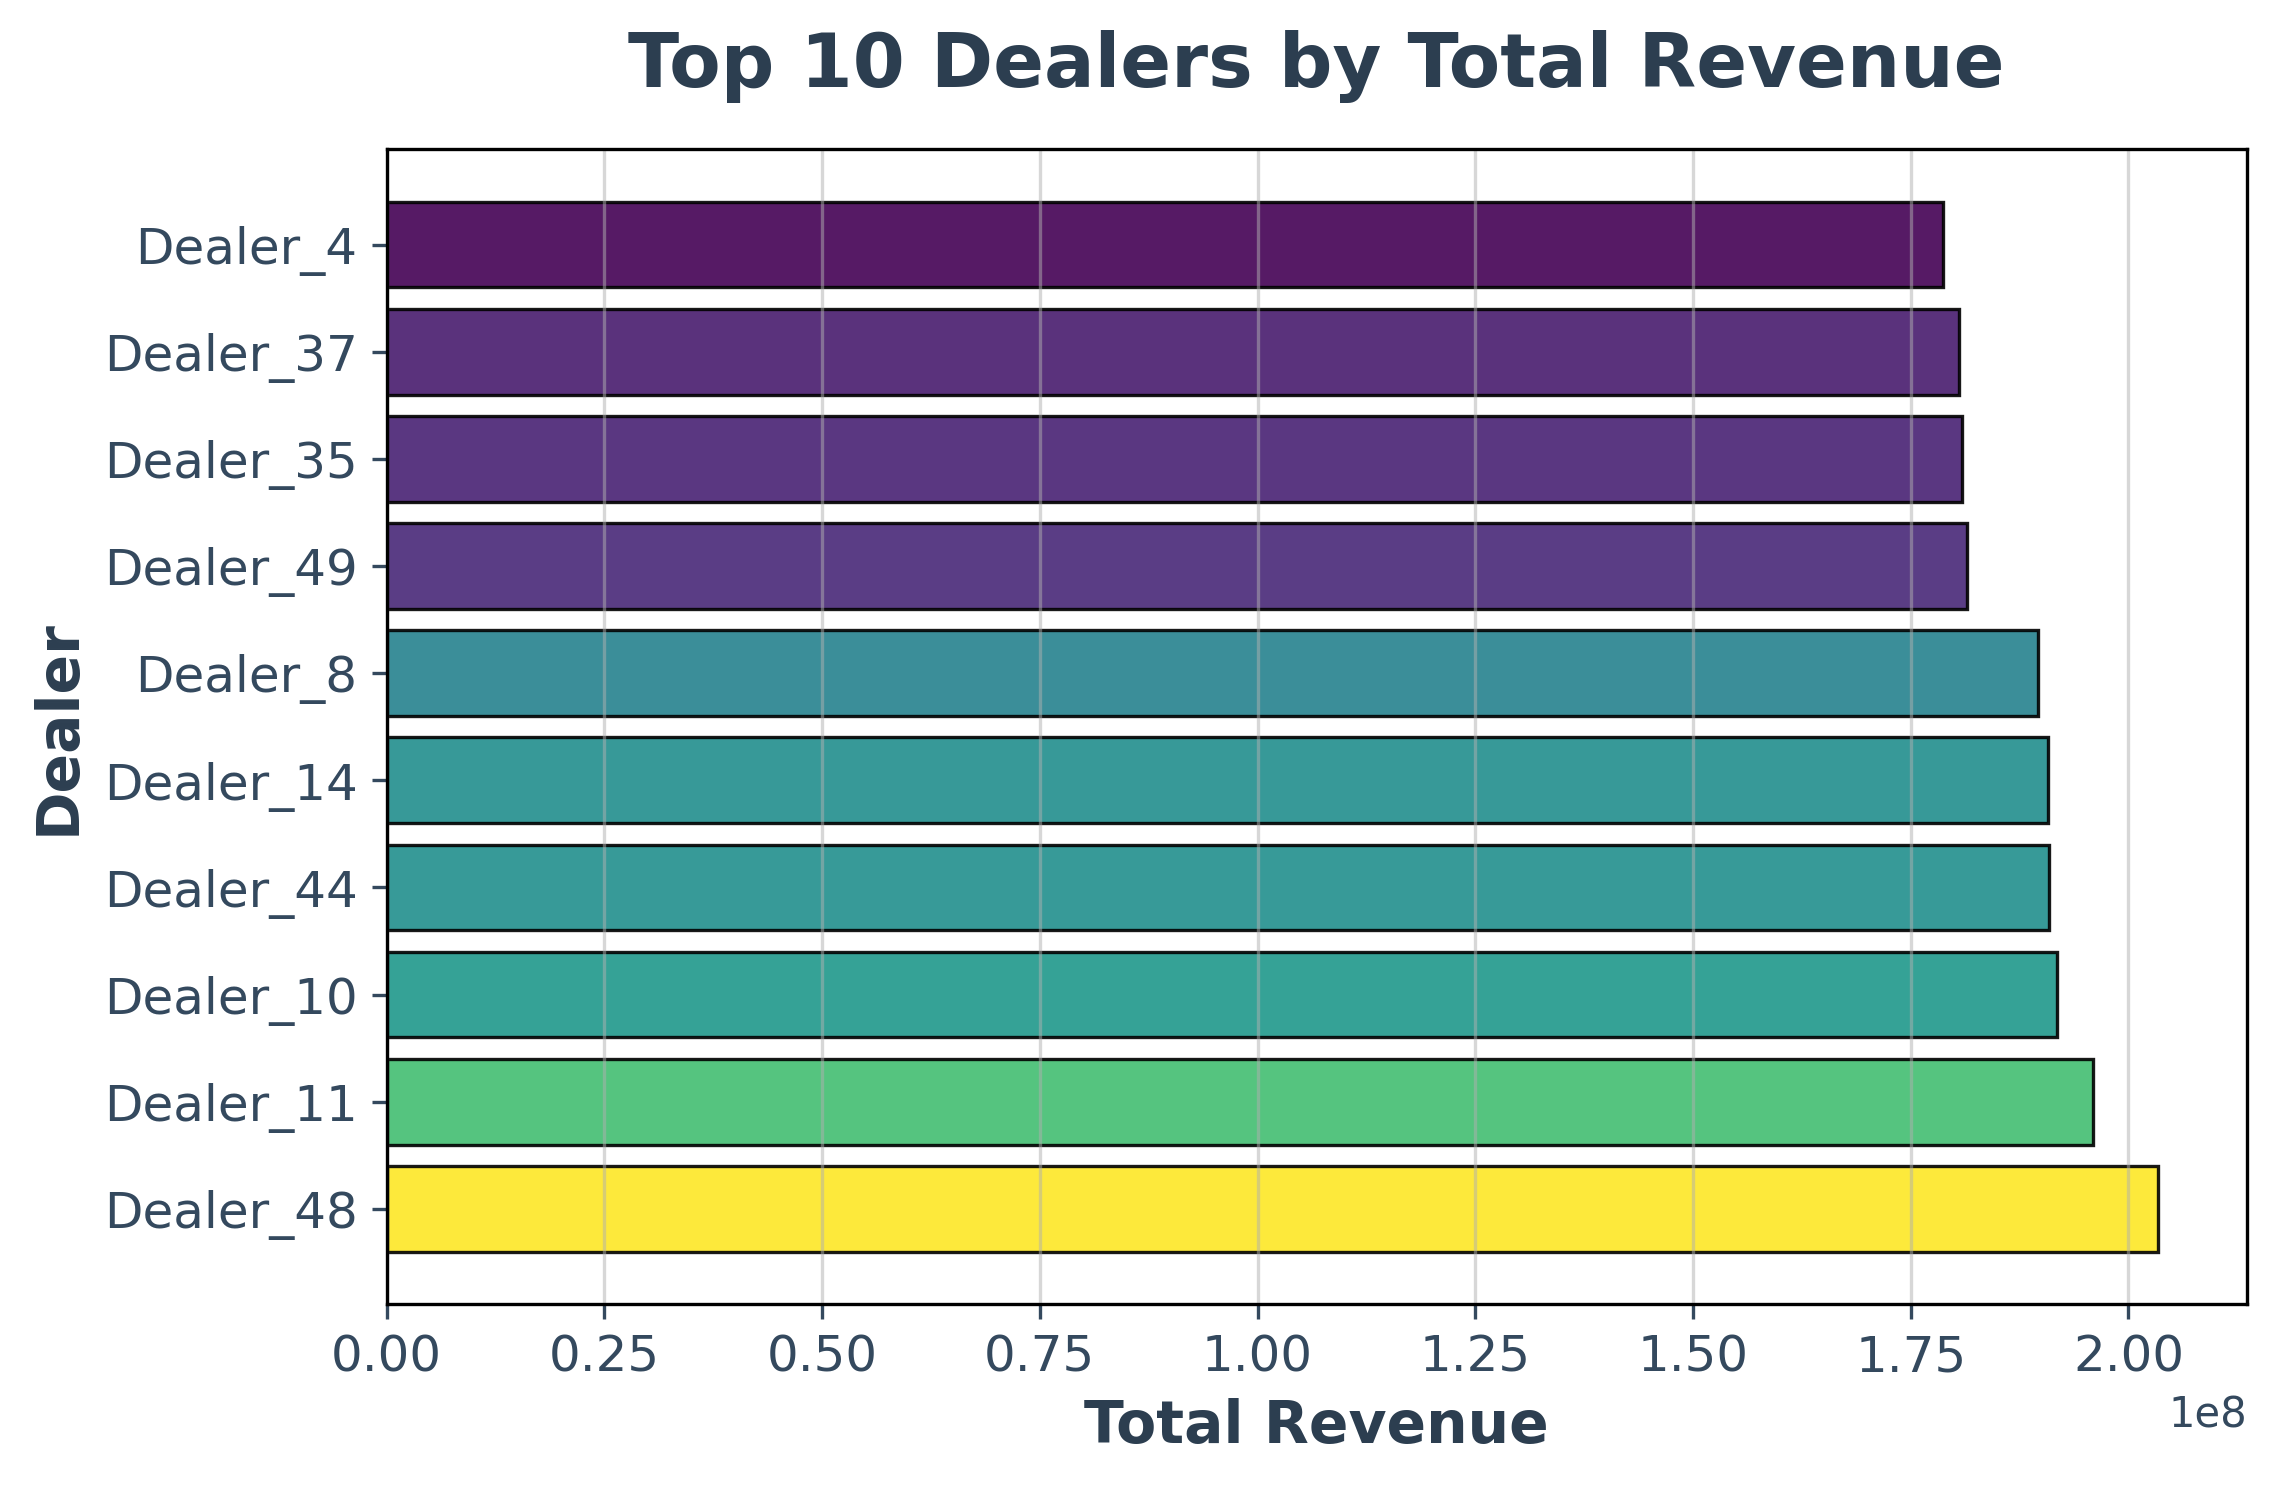

In [115]:
fig, ax = plt.subplots(dpi=300, figsize=(8, 5))

norm = plt.Normalize(min(total_revenue), max(total_revenue))
colors = cm.viridis(norm(total_revenue))

bars = ax.barh(
    y=dealers,
    width=total_revenue,
    color=colors,
    edgecolor="black",
    linewidth=0.8,
    alpha=0.9,
)

ax.grid(axis="x", linestyle="-", alpha=0.5)

ax.set_title(
    "Top 10 Dealers by Total Revenue",
    fontsize=18,
    fontweight="bold",
    color="#2c3e50",
    pad=15,
)
ax.set_xlabel("Total Revenue", fontsize=14, fontweight="bold", color="#2c3e50")
ax.set_ylabel("Dealer", fontsize=14, fontweight="bold", color="#2c3e50")

ax.tick_params(axis="x", labelsize=12, colors="#34495e")
ax.tick_params(axis="y", labelsize=12, colors="#34495e")

plt.savefig("images/top10_dealers_by_total_revenue.png", dpi=1200, bbox_inches="tight")
plt.show()

### IX. Fuel Type Trend Over Years

In [100]:
fuel_trend_over_years = spark.sql(
    """
    select year, fuel_type, sum(units_sold) as total_units 
    from bmw
    group by year, fuel_type
    order by year, fuel_type
    """
)
fuel_trend_over_years.show(8)

+----+---------+-----------+
|year|fuel_type|total_units|
+----+---------+-----------+
|2010|   Diesel|       1910|
|2010| Electric|       2193|
|2010|   Hybrid|       2000|
|2010|   Petrol|       1880|
|2011|   Diesel|       2068|
|2011| Electric|       2091|
|2011|   Hybrid|       1930|
|2011|   Petrol|       2172|
+----+---------+-----------+
only showing top 8 rows


In [97]:
# Collect everything JUST ONCE
rows = fuel_trend_over_years.collect()
years = list(range(2010, 2025))

year_data = {year: {} for year in years}

for row in rows:
    year = row["year"]
    fuel = row["fuel_type"]
    units = row["total_units"]

    if year in year_data:
        year_data[year][fuel] = units

print(year_data)

{2010: {'Diesel': 1910, 'Electric': 2193, 'Hybrid': 2000, 'Petrol': 1880}, 2011: {'Diesel': 2068, 'Electric': 2091, 'Hybrid': 1930, 'Petrol': 2172}, 2012: {'Diesel': 1914, 'Electric': 2274, 'Hybrid': 1703, 'Petrol': 1766}, 2013: {'Diesel': 1763, 'Electric': 1868, 'Hybrid': 1827, 'Petrol': 1853}, 2014: {'Diesel': 2024, 'Electric': 1962, 'Hybrid': 1732, 'Petrol': 1903}, 2015: {'Diesel': 1545, 'Electric': 1604, 'Hybrid': 2326, 'Petrol': 1803}, 2016: {'Diesel': 2082, 'Electric': 1853, 'Hybrid': 1734, 'Petrol': 2041}, 2017: {'Diesel': 1858, 'Electric': 2019, 'Hybrid': 1877, 'Petrol': 1983}, 2018: {'Diesel': 2058, 'Electric': 1685, 'Hybrid': 1913, 'Petrol': 1906}, 2019: {'Diesel': 1718, 'Electric': 1587, 'Hybrid': 1699, 'Petrol': 1918}, 2020: {'Diesel': 2104, 'Electric': 1713, 'Hybrid': 2328, 'Petrol': 1886}, 2021: {'Diesel': 2280, 'Electric': 1832, 'Hybrid': 1759, 'Petrol': 1997}, 2022: {'Diesel': 1881, 'Electric': 2235, 'Hybrid': 1989, 'Petrol': 1969}, 2023: {'Diesel': 1982, 'Electric': 18

In [102]:
diesel_values = [year_data[year]["Diesel"] for year in years]
electric_values = [year_data[year]["Electric"] for year in years]
hybrid_values = [year_data[year]["Hybrid"] for year in years]
petrol_values = [year_data[year]["Petrol"] for year in years]

In [103]:
colors = {
    "Petrol": "#1f77b4",
    "Electric": "#2ca02c",
    "Hybrid": "#ff7f0e",
    "Diesel": "#d62728",
}

marker_faces = {
    "Petrol": "#aec7e8",
    "Electric": "#98df8a",
    "Hybrid": "#ffbb78",
    "Diesel": "#ff9896",
}

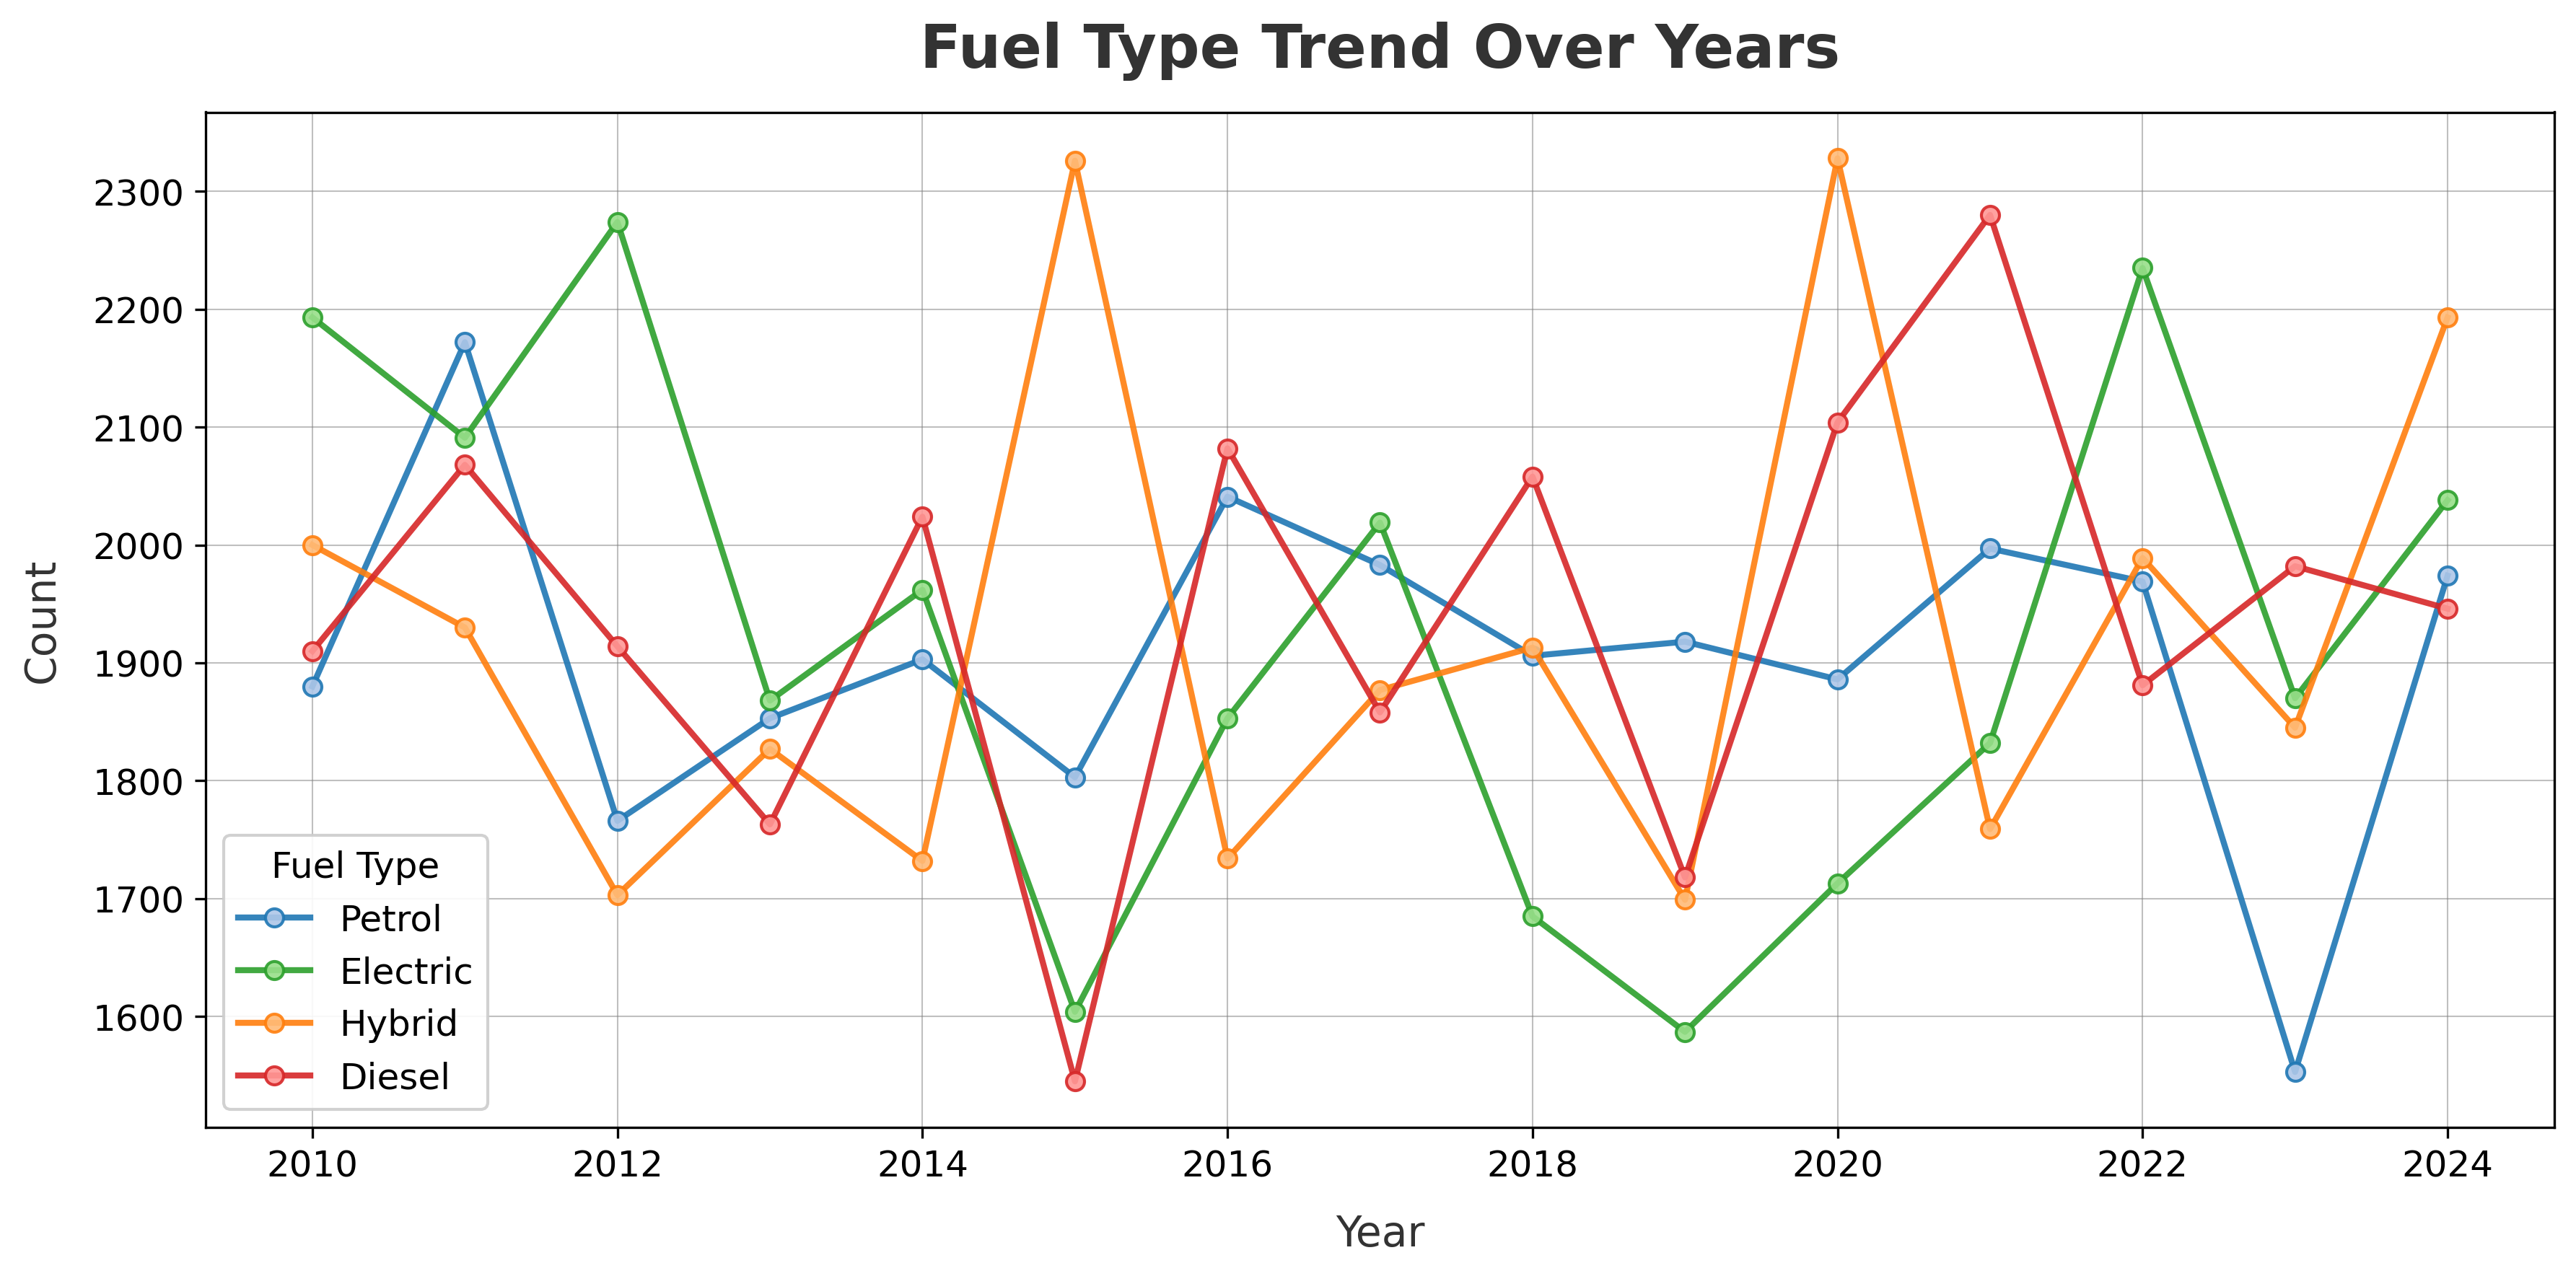

In [107]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.plot(
    years,
    petrol_values,
    color=colors["Petrol"],
    marker="o",
    markerfacecolor=marker_faces["Petrol"],
    markeredgecolor=colors["Petrol"],
    alpha=0.9,
    label="Petrol",
    linewidth=2,
)

ax.plot(
    years,
    electric_values,
    color=colors["Electric"],
    marker="o",
    markerfacecolor=marker_faces["Electric"],
    markeredgecolor=colors["Electric"],
    alpha=0.9,
    label="Electric",
    linewidth=2,
)

ax.plot(
    years,
    hybrid_values,
    color=colors["Hybrid"],
    marker="o",
    markerfacecolor=marker_faces["Hybrid"],
    markeredgecolor=colors["Hybrid"],
    alpha=0.9,
    label="Hybrid",
    linewidth=2,
)

ax.plot(
    years,
    diesel_values,
    color=colors["Diesel"],
    marker="o",
    markerfacecolor=marker_faces["Diesel"],
    markeredgecolor=colors["Diesel"],
    alpha=0.9,
    label="Diesel",
    linewidth=2,
)

ax.grid(
    visible=True,
    which="major",
    axis="both",
    color="gray",
    linestyle="-",
    linewidth=0.5,
    alpha=0.5,
)

ax.set_title(
    "Fuel Type Trend Over Years",
    fontsize=20,
    fontweight="bold",
    color="#333333",
    pad=15,
)
ax.set_xlabel("Year", fontsize=14, color="#333333", labelpad=10)
ax.set_ylabel("Count", fontsize=14, color="#333333", labelpad=10)

ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.legend(
    title="Fuel Type", fontsize=12, title_fontsize=12, frameon=True, framealpha=0.9
)

plt.tight_layout()
plt.savefig("images/fuel_type_trend_over_years.png", dpi=1200, bbox_inches="tight")
plt.show()